# Predictive Churn Analysis for Telecom Services Using Machine Learning

## Project Description
The telecom company Interconnect would like to identify customers who are likely to discontinue their services so they can proactively reach out to them with targeted promotions and customer retention plans. The company has provided files containing information about their customers.

This project focuses on creating a predictive model to tell which customers are likely to keep or discontinue their services.  

A thorough exploratory data analysis will provide context, uncover trends, and guide feature engineering. This includes initial analysis of the contract, personal, internet, and phone data sets.

The primary performance metric, the AUC-ROC score, will gauge the model's success in finding potential churn from loyal customers. Accuracy will be used as a secondary metric to measure the model's overall performance. 

## Data Description
The data is split between four files that can be joined by the customerID column:

- contract.csv — information regarding each customer's contract
- personal.csv — demographic information about each customer
- internet.csv — information regarding specific internet services per customer
- phone.csv — information regarding phone services per customer

### Interconnect's services
Interconnect provides two main types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Some additional services the company provides include:

- Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
- A dedicated technical support line (TechSupport)
- Cloud file storage and data backup (OnlineBackup)
- TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose either a monthly payment or sign a 1- or 2-year contract.

# Setup

In [126]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

In [127]:
# Set random state
random_state = 42 

# Set default figure size
plt.rcParams['figure.figsize'] = [6, 4]

# Set default style
palette = sns.color_palette('ocean')
palette = (palette[0],) + tuple(palette[3:])  # Remove the second and third colors
sns.set(palette=palette)

# tight layout as default
plt.rcParams['figure.autolayout'] = True


# Load Data

In [128]:
def find_path():
    # If '/datasets' is in the current directory, TripTen Hub
    if os.path.exists('/datasets'):
        path = '/datasets/'
        print('Running on TripTen Hub')
    else: # Local machine
        path = ''
        print('Running on local machine')
    return path

In [129]:
def load_data(file_name):
    try: # Load Locally
        data = pd.read_csv('final_provider/' + file_name)
    except: # Load from TripTen
        data = pd.read_csv('/datasets/final_provider/' + file_name)
    return data

In [130]:
path = find_path()

Running on local machine


In [131]:
# Get file names in the final_provider directory, exclude hidden files
file_names = [f for f in os.listdir(path + 'final_provider') if not f.startswith('.')]
print(file_names)

# Dictionary to store data frames
data_frames = {}

# Display the first 5 rows of each file
for file_name in file_names:
    # Create a variable name based on the file name
    variable_name = file_name.split('.')[0] + '_df'
    data_frames[variable_name] = load_data(file_name)
    # Set a custom attribute to store the name
    data_frames[variable_name].name = variable_name
    # Change 'customerID' to CustomerID
    data_frames[variable_name].rename(columns={'customerID': 'CustomerID'}, inplace=True)
    # Change 'gender' to 'Gender'
    if 'gender' in data_frames[variable_name].columns:
        data_frames[variable_name].rename(columns={'gender': 'Gender'}, inplace=True)
    display(data_frames[variable_name].head())

['personal.csv', 'contract.csv', 'phone.csv', 'internet.csv']


,CustomerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,CustomerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


EndDate (the target) is present in the contracts table.

## Merge Data

In [132]:
def merge_assertions(data_frames):
    # Assert that each table as no duplicates for CustomerID
    for df in data_frames:
        assert data_frames[df].CustomerID.duplicated().sum() == 0
        
    # Assert that each table has no missing values
    for df in data_frames:
        assert data_frames[df].isnull().sum().sum() == 0
    
    # Assert that personal_df and contract_df have the same CustomerIDs
    assert data_frames['personal_df'].CustomerID.equals(data_frames['contract_df'].CustomerID)
    
    # Assert that each Customer ID in phone_df and internet_df exists in contract_df
    assert data_frames['phone_df'].CustomerID.isin(data_frames['contract_df'].CustomerID).all()
    assert data_frames['internet_df'].CustomerID.isin(data_frames['contract_df'].CustomerID).all()
    
    print('*** All assertions passed! ***')

merge_assertions(data_frames)


*** All assertions passed! ***


In [133]:
# Since assertions have passed, we can now merge the DataFrames.
# NaN values will mean the customer does not have that service.
# Blank DataFram to store the merged data
data_all = pd.DataFrame(columns=['CustomerID'])

# Merge all dataframes
for df in data_frames:
    data_all = pd.merge(data_all, data_frames[df], on='CustomerID', how='outer')

# Assertion function states there are no missing values in each individual dataframe so we are safe to fill NaN values with "No Service"
data_all.fillna('No Service', inplace=True)
    
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


## Clean Data

In [134]:
# # Print value counts for each column
# for col in data_all.columns:
#     print(data_all[col].value_counts())
#     print(f"NaN count: {data_all[col].isna().sum()}\n")

- Some boolean columns are stored as strings. 
- Only 4 dates with cancelled contracts? The contract information is valid as of February 1, 2020.
- Dates are stored as strings.
- TotalCharges is stored as a string.

#### Dates

In [135]:
# Convert BeginDate and EndDate to datetime
# Convert 'No' to NaN
data_all['EndDate'].replace('No', np.nan, inplace=True)

# Convert BeginDate and EndDate to datetime
data_all['BeginDate'] = pd.to_datetime(data_all['BeginDate'])
data_all['EndDate'] = pd.to_datetime(data_all['EndDate'])

assert data_all['BeginDate'].dt.day.value_counts().index[0] == 1 # All begin dates are on the first of the month
assert data_all['BeginDate'].dt.time.value_counts().index[0].hour == 0 # All begin dates are at midnight

assert data_all['EndDate'].dt.day.value_counts().index[0] == 1 # All end dates are on the first of the month
assert data_all['EndDate'].dt.time.value_counts().index[0].hour == 0 # All end dates are at midnight

# Trim the day and time from the date
data_all['BeginDate'] = data_all['BeginDate'].dt.to_period('M')
data_all['EndDate'] = data_all['EndDate'].dt.to_period('M')

#### Boolean Columns

In [136]:
# Convert columns to boolean

convert_to_bool_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
for col in convert_to_bool_cols:
    # Replace 'Yes' with 1 and 'No' with 0
    data_all[col].replace({'Yes':1, 'No':0}, inplace=True)
    # Convert to int
    data_all[col] = data_all[col].astype('int32')

# Make a boolean Gender column
data_all['Male'] = data_all['Gender'].replace({'Male':1, 'Female':0}).astype('int32')


#### Total Charges

In [137]:
# Print empty string count
print(f"There are {data_all[data_all['TotalCharges']==' '].shape[0]} empty strings in TotalCharges because these contracts all started in the same month as the data was pulled.\nConverting the column to float, empty strings will be converted to NaN.")

# Convert TotalCharges to float
data_all['TotalCharges'] = pd.to_numeric(data_all['TotalCharges'], errors='coerce')

print(f"TotalCharges has {data_all['TotalCharges'].isna().sum()} NaN values, or {data_all['TotalCharges'].isna().sum()/data_all.shape[0]*100:.2f}% of the data.")
print("We will drop these rows since it is a small percentage of the data and the data is too recent to be considered mature.")
data_all.dropna(subset=['TotalCharges'], inplace=True)
data_all.reset_index(drop=True, inplace=True)

# Assert that there is no begin date = or after 2020-02
assert data_all['BeginDate'].max() < pd.Period('2020-02')

There are 11 empty strings in TotalCharges because these contracts all started in the same month as the data was pulled.
Converting the column to float, empty strings will be converted to NaN.
TotalCharges has 11 NaN values, or 0.16% of the data.
We will drop these rows since it is a small percentage of the data and the data is too recent to be considered mature.


#### Review Cleaned Data

In [138]:
print(f"There are {data_all['EndDate'].isna().sum()} NaN values in the EndDate column. These are the customers who are still with the company.\n")

print(data_all.info())

There are 5163 NaN values in the EndDate column. These are the customers who are still with the company.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   CustomerID        7032 non-null   object   
 1   Gender            7032 non-null   object   
 2   SeniorCitizen     7032 non-null   int32    
 3   Partner           7032 non-null   int32    
 4   Dependents        7032 non-null   int32    
 5   BeginDate         7032 non-null   period[M]
 6   EndDate           1869 non-null   period[M]
 7   Type              7032 non-null   object   
 8   PaperlessBilling  7032 non-null   int32    
 9   PaymentMethod     7032 non-null   object   
 10  MonthlyCharges    7032 non-null   float64  
 11  TotalCharges      7032 non-null   float64  
 12  MultipleLines     7032 non-null   object   
 13  InternetService   7032 non-null   object   
 14

## Feature Engineering I

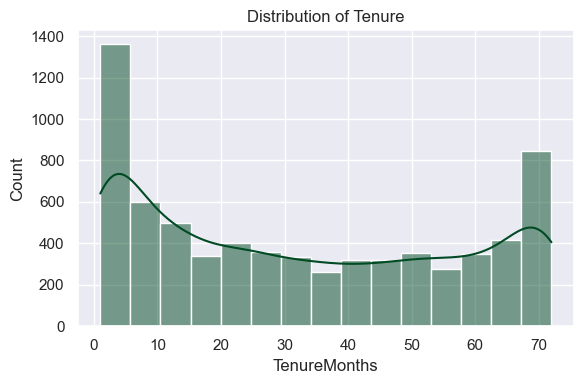

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: TenureMonths, dtype: float64

Question: What percent of TotalCharges is >= MonthlyCharges * Tenure?
Answer: 54.29 %

Question: What percent of TotalCharges is == MonthlyCharges * Tenure?
Answer: 8.73 %


In [139]:
# Create the Tenure column in months, contracts with no end date are still active as of 2020-02-01
data_all['TenureMonths'] = (data_all['EndDate'].fillna(pd.Period('2020-02', 'M')) - data_all['BeginDate']).apply(lambda x: x.n).astype('int')

# Plot the distribution of Tenure
sns.histplot(data_all['TenureMonths'], kde=True)
plt.title('Distribution of Tenure')
#
plt.show()

# Describe the TenureMonths column
print(data_all['TenureMonths'].describe())

print("\nQuestion: What percent of TotalCharges is >= MonthlyCharges * Tenure?")
print("Answer:", round((data_all['TotalCharges'] >= data_all['MonthlyCharges'] * data_all['TenureMonths']).sum() / data_all.shape[0] * 100, 2), "%")

print("\nQuestion: What percent of TotalCharges is == MonthlyCharges * Tenure?")
print("Answer:", round((data_all['TotalCharges'] == data_all['MonthlyCharges'] * data_all['TenureMonths']).sum() / data_all.shape[0] * 100, 2), "%")

Total Charges very rarely equals Monthly Charges multiplied by Total Months. This is likely because of additional fees or discounts.

In [140]:
# Create 'Churn' column, which is True if 'EndDate' is not null, and False otherwise
data_all['Churn'] = data_all['EndDate'].notna()
data_all['Churn'] = data_all['Churn'].astype('int32')
print(data_all['Churn'].value_counts())

Churn
0    5163
1    1869
Name: count, dtype: int64


In [141]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   CustomerID        7032 non-null   object   
 1   Gender            7032 non-null   object   
 2   SeniorCitizen     7032 non-null   int32    
 3   Partner           7032 non-null   int32    
 4   Dependents        7032 non-null   int32    
 5   BeginDate         7032 non-null   period[M]
 6   EndDate           1869 non-null   period[M]
 7   Type              7032 non-null   object   
 8   PaperlessBilling  7032 non-null   int32    
 9   PaymentMethod     7032 non-null   object   
 10  MonthlyCharges    7032 non-null   float64  
 11  TotalCharges      7032 non-null   float64  
 12  MultipleLines     7032 non-null   object   
 13  InternetService   7032 non-null   object   
 14  OnlineSecurity    7032 non-null   object   
 15  OnlineBackup      7032 non-null   object   
 16  Device

In [142]:
def data_all_assertions(data_all):
    
    # No duplicates
    assert data_all.duplicated().sum() == 0
    # No CustomerID duplicates
    assert data_all['CustomerID'].duplicated().sum() == 0
    # No missing values except for in EndDate (will be dropped in training)
    for col in data_all.columns:
        if col != 'EndDate':
            assert data_all[col].isnull().sum() == 0

    
    print('*** All assertions passed! ***')

data_all_assertions(data_all)

*** All assertions passed! ***


# EDA

In [143]:
def plot_target_balance(df):
    
    plot_df = df.copy()
    
    # Replace 1 with 'Churn' and 0 with 'Stay'
    plot_df['Churn'] = plot_df['Churn'].replace({1: 'Churn', 0: 'Stay'})
    
    print(plot_df['Churn'].value_counts())
    
    # Make a pie chart
    plot_df['Churn'].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title('Churn Balance')
    plt.ylabel('')
    plt.show()

In [144]:
def plot_three_distributions(df, columm):
    # Make a three subplot figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    plt.subplots_adjust(wspace=0.175)
    
    # Split the column str at the second capital letter
    match = re.finditer(r'[A-Z]', columm)
    positions = [m.start() for m in match]
    if len(positions) >= 2:
        suptitle = columm[:positions[1]] + ' ' + columm[positions[1]:]
    else:
        suptitle = columm

    # Set the title
    fig.suptitle(suptitle)
    

    # Boxplot of Total Charges
    sns.boxplot(data=df, hue='Churn', y=columm, ax=axs[0], dodge=True, width=0.6)
    axs[0].set_title('Boxplot')

    # Plot the distribution of total charges
    sns.histplot(data=df, x=columm, hue='Churn', kde=True, ax=axs[1], stat='density', common_norm=False)
    axs[1].set_title('Distribution')

    # Plot kde cumulative distribution of total charges
    sns.kdeplot(data=df, x=columm, hue='Churn', cumulative=True, common_norm=False, ax=axs[2])
    axs[2].set_title('Cumulative Distribution')
    
    plt.show()

In [145]:
def plot_column_balance(df, column, rotation=0):
    
    churn_counts = data_all.groupby([column, 'Churn']).size().unstack()
    
    # Make two subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    plt.subplots_adjust(wspace=0.175)
    
    # Split the column str at the second capital letter
    match = re.finditer(r'[A-Z]', column)
    positions = [m.start() for m in match]
    if len(positions) >= 2:
        suptitle = column[:positions[1]] + ' ' + column[positions[1]:]
    else:
        suptitle = column
    
    # Set the title
    fig.suptitle(suptitle + ' Balance')
    
    # Reverse column order
    churn_counts = churn_counts.iloc[:, ::-1]
    # Bar plot
    churn_counts.plot(kind='bar', stacked=True, ax=axs[1], color=palette[0:2][::-1])
    # Set the title
    axs[1].set_title('Stacked Bar')
    # Labels
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=rotation)
    axs[1].set_ylabel('Count')
    axs[1].set_xlabel("")
    
    # Reverse column order
    churn_counts = churn_counts.iloc[:, ::-1]
    # Rotate churn_counts
    churn_counts = churn_counts.T
    # Plot a heatmap
    sns.heatmap(churn_counts, annot=True, fmt='d', ax=axs[0])
    # Set the title
    axs[0].set_title('Heatmap')
    # Labels
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=rotation)
    axs[0].set_xlabel("")
    
    
    plt.show()
    
    
    # Add a percentage column
    if churn_counts.shape[1] == 2:
        churn_counts['ShareOfCategories%'] = churn_counts.apply(
            lambda row: f"{(row.iloc[0] / row.sum() * 100):.0f}/{(row.iloc[1] / row.sum() * 100):.0f}", axis=1)
    elif churn_counts.shape[1] == 3:
        churn_counts['ShareOfCategories%'] = churn_counts.apply(
            lambda row: f"{(row.iloc[0] / row.sum() * 100):.0f}/{(row.iloc[1] / row.sum() * 100):.0f}/{(row.iloc[2] / row.sum() * 100):.0f}", axis=1)
    elif churn_counts.shape[1] == 4:
        churn_counts['ShareOfCategories%'] = churn_counts.apply(
            lambda row: f"{(row.iloc[0] / row.sum() * 100):.0f}/{(row.iloc[1] / row.sum() * 100):.0f}/{(row.iloc[2] / row.sum() * 100):.0f}/{(row.iloc[3] / row.sum() * 100):.0f}", axis=1)
    else:
        raise ValueError('Too many categories, only 2, 3, or 4 categories are supported.')

    return churn_counts
    
    

## What is the balance of the target variable?

Churn
Stay     5163
Churn    1869
Name: count, dtype: int64


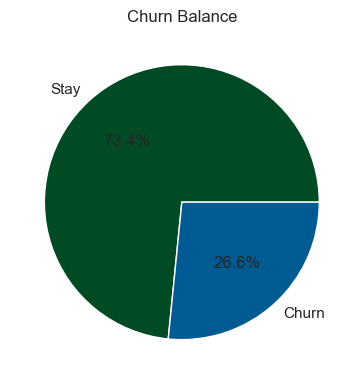

In [146]:
plot_target_balance(data_all)

There is an imbalance in the target variable. I will consider upsampling the minority class, and using the 'balanced' class_weight parameter when training the models.

## What is the distribution of total charges?

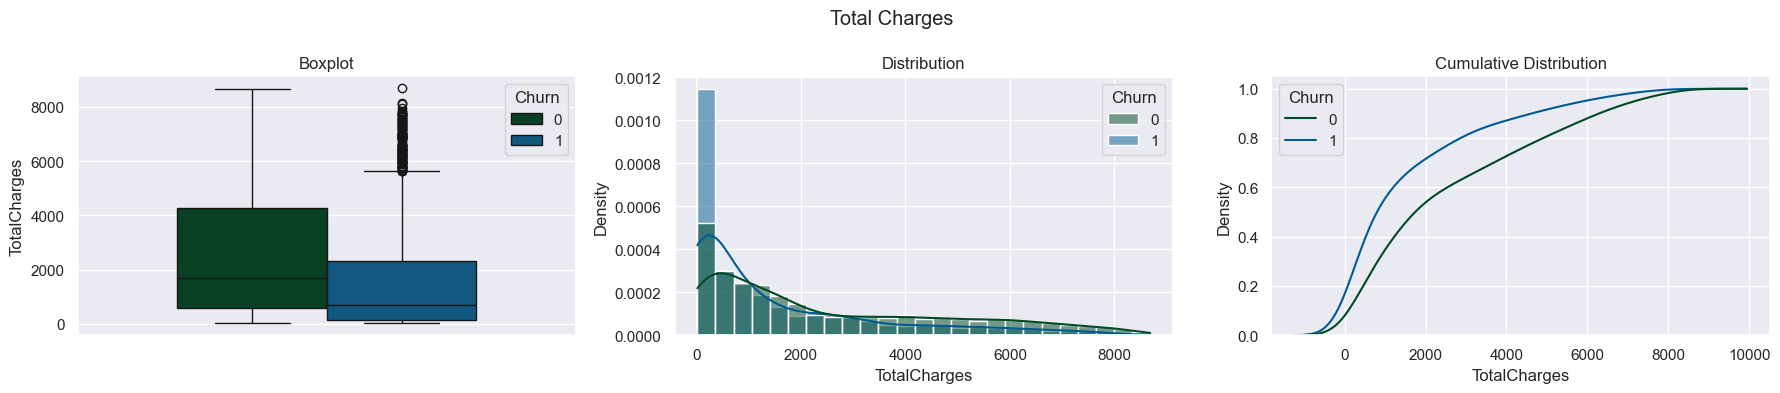

Correlation to Churn: -0.1994840835675645


In [147]:
plot_three_distributions(data_all, 'TotalCharges')

# Correlation:
print("Correlation to Churn:",data_all['TotalCharges'].corr(data_all['Churn']))

- The **box plot** reveals a lower median total charge for churned customers compared to non-churned customers. The lower quartile for churned customers is also lower than that of non-churned customers, indicating that a larger proportion of churned customers have lower total charges. This suggests that churned customers may not have been with the company for as long as non-churned customers, resulting in lower total charges. The extended upper whisker for non-churned customers indicates a broader range of higher total charges, likely due to their longer relationship with the company. In contrast, the shorter upper whisker and concentration of outliers around the top whisker for churned customers suggest that while most churned customers have lower total charges, a small subset of them accumulated charges comparable to long-term customers before churning.

- The **distribution plot** shows churned and non-churned taking on similar shapes, with the highest concentration of customers at the low end of total charges. However, churned customers have a higher concentration at lower total charges that steeply drops off, while non-churned customers have a more gradual decline in concentration as total charges increase. Again, this is likely due to churned customers not being with the company for as long as non-churned customers.

- The **cumulative distribution plot** shows that a larger proportion of churned customers have higher total charges, with about 75% of them have total charges below $2000, while about 55% of non-churned customers have total charges below $2000. 

## What is the distribution of monthly charges?

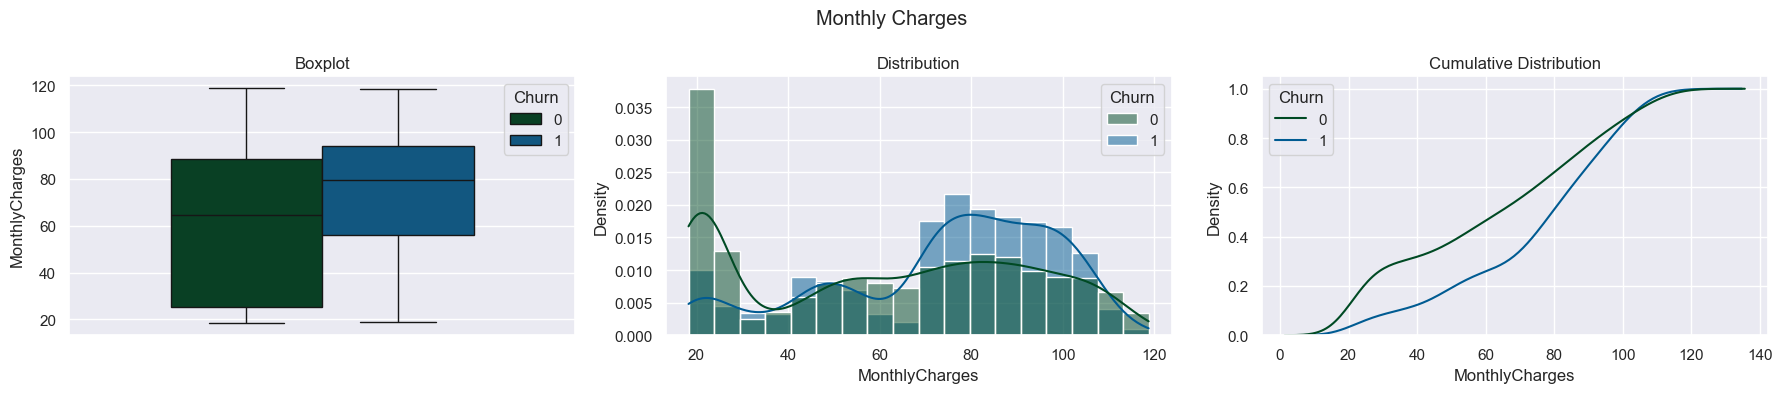

Correlation to Churn: 0.19285821847007897


In [148]:
plot_three_distributions(data_all, 'MonthlyCharges')
print("Correlation to Churn:",data_all['MonthlyCharges'].corr(data_all['Churn']))

- The **box plot** shows that customers who churned generally have higher monthly charges, with the median monthly charge for churned customers around $80, compared to about $65 for those who did not churn. The lower quartile for churned customers is also much higher than that of non-churned customers, indicating that a larger proportion of churned customers have higher monthly charges.  

- The **distribution plot** indicates a higher concentration of customers who did not churn at lower monthly charges (around $20), whereas churned customers are more prevalent at higher monthly charges (starting around $70). The distribution of monthly charges for churned customers is also more spread out, with a wider range of monthly charges compared to non-churned customers who have a more concentrated distribution around lower monthly charges. Both categories have similar kde shapes, but churned customers have a higher concentration at higher monthly charges.

- The **cumulative distribution plot** reinforces that non-churned customers generally have lower monthly charges, while churned customers tend to have higher charges. 40% of non-churned customers have charges at or below $50, while only 20% of churned customers have charges at or below $50. The lines cross near the upper right corner, indicating that at very high MonthlyCharges, churned customers have a higher concentration.

## What is the distribution of tenure?

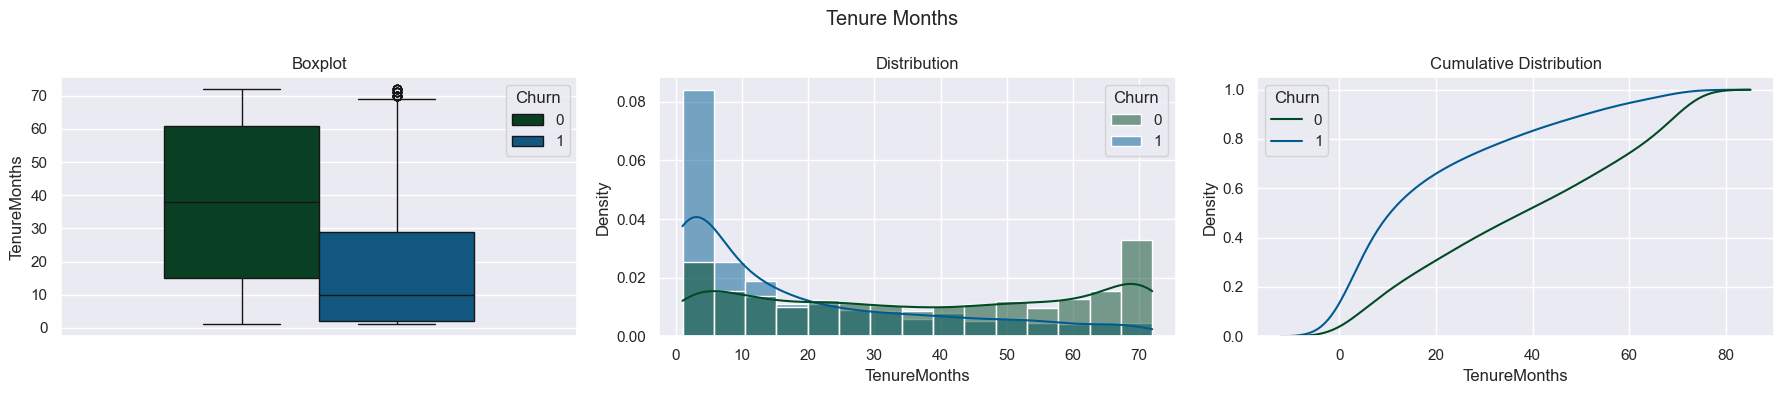

Correlation to Churn: -0.3540493589532514


In [149]:
plot_three_distributions(data_all, 'TenureMonths')
print("Correlation to Churn:",data_all['TenureMonths'].corr(data_all['Churn']))

- The **box plot** shows that churned customers have shorter tenures compared to non-churned customers. The median tenure for churned customers is around 10 months, while the median tenure for non-churned customers is around 40 months. The lower quartile for churned customers is also lower than that of non-churned customers, indicating that a larger proportion of churned customers have shorter tenures. The extended upper whisker and outliers for churned customers suggests that while most churned customers have shorter tenures, a small subset of them have longer tenures before churning.  

- The **distribution plot** shows churned customers have a peak around 1 month with a steep right skew, re-enforcing that most churned customers have short tenures. In contrast, the distribution of tenure for non-churned customers is more evenly spread out, with slight peaks at both extremes. 

- The **cumulative distribution plot** shows again the churned customers have a higher concentration at lower tenures, with about 50% having tenures below 10 months. In contrast, the non-churned customers have a more even distribution of tenures, with only about 15% having tenures below 10 months.

**Note:** Tenure in conjunction with BeginDate will cause data leakage if included in the training features - the model will conclude if BeginDate + Tenure is less than February 1, 2020 then the customer churned.

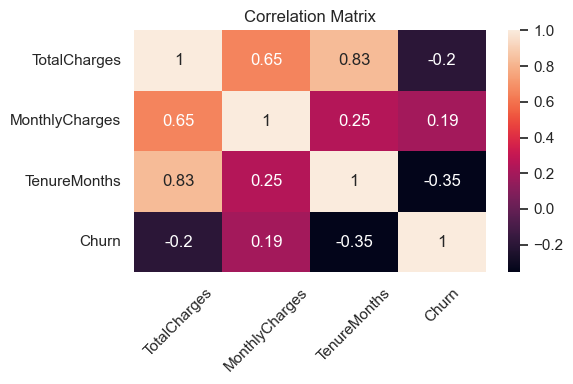

In [150]:
# Correlation matrix
corr = data_all[['TotalCharges', 'MonthlyCharges', 'TenureMonths', 'Churn']].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

The correlation matrix summarizes and contextualizes what we have explored individually up to this point. Tenure has the strongest correlation with the target variable, showing that shorter tenures are associated with higher churn rates. Some correlations are expected given the nature of the data. For example, the negative correlation with total charges is expected since customers who churned have shorter tenures and therefore lower total charges - this is likely to cause data leakage. However, the positive correlation between monthly charges and churn tells us that customers who churn tend to have higher monthly charges.

## What is the trend for acquiring and churning customers?

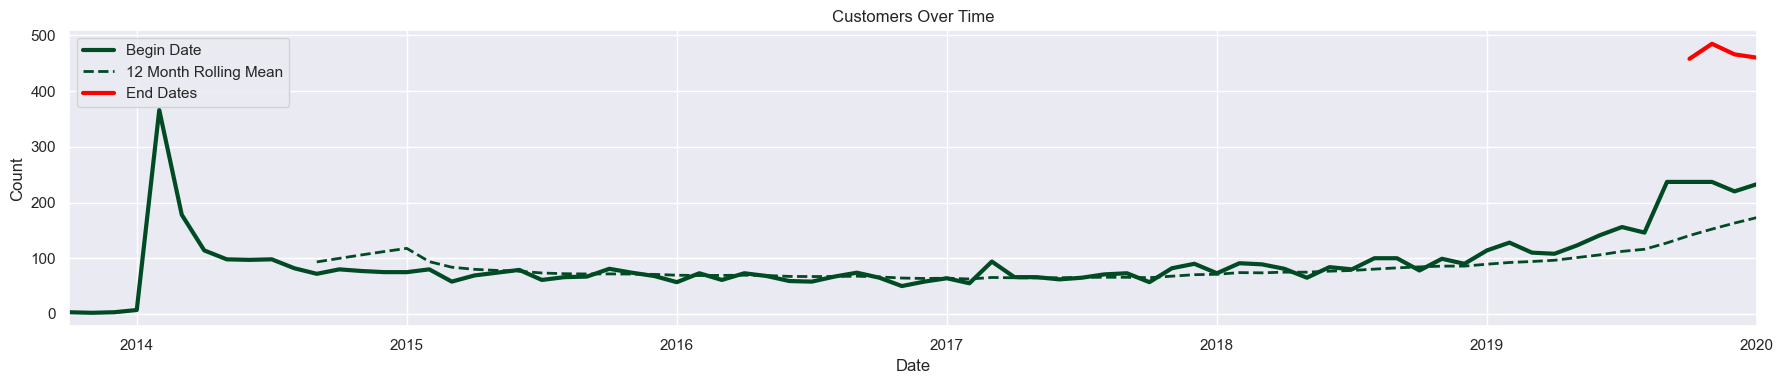

### BeginDate Stats ###
min: 2013-10
max: 2020-01
count        7032
unique         76
top       2014-02
freq          366
Name: BeginDate, dtype: object

### EndDate Stats ###
min: 2019-10
max: 2020-01
count        1869
unique          4
top       2019-11
freq          485
Name: EndDate, dtype: object


In [151]:
# Plot BeginDate
plt.figure(figsize=(18, 4))
plt.title('Customers Over Time')

# Plot monthly counts
data_all['BeginDate'].value_counts().sort_index().plot(label="Begin Date", linewidth=3)

# Plot annual rolling average
data_all['BeginDate'].value_counts().sort_index().rolling(12).mean().plot(label="12 Month Rolling Mean", linewidth=2, color=palette[0], linestyle='--')

# Plot EndDate
data_all['EndDate'].value_counts().sort_index().plot(label="End Dates", linewidth=3, color='red')

# Set labels
plt.xlabel('Date')
plt.ylabel('Count')

plt.legend()
plt.show()

print("### BeginDate Stats ###")
print(f"min: {data_all['BeginDate'].min()}")
print(f"max: {data_all['BeginDate'].max()}")
print(data_all['BeginDate'].describe())
print()
print("### EndDate Stats ###")
print(f"min: {data_all['EndDate'].min()}")
print(f"max: {data_all['EndDate'].max()}")
print(data_all['EndDate'].describe())

**Acquisition Trend**  
We can see that the company ramped up their customer acquisition over a few months, then quickly dropped off for the next 6 months or so to about 100 new customers per month. After that the company had a slight downward trend in customer acquisition until about 2017-01 with a new customer count of about 60. From there the company has been steadily increasing their customer acquisition with a big spike in mid 2019, acquiring just less than 250 new customers per month. All in all, the company has been on a good upward trajectory in customer acquisition over the last few years.  

**Earliest Customers**  
Also of note is the big spike in february 2014, I thought this might be when the company started, but there are a few records before that. Lets take a closer look at the oldest records.

In [152]:
print(data_all['BeginDate'].value_counts().sort_index().head(12))

BeginDate
2013-10      3
2013-11      2
2013-12      3
2014-01      7
2014-02    366
2014-03    178
2014-04    114
2014-05     98
2014-06     97
2014-07     98
2014-08     82
2014-09     72
Freq: M, Name: count, dtype: int64


Starting in 2013-10 there are a few records per month until 2014-02 where the spike is. The company did start at the minimum date, but took a few months for their marketing to draw in customers.

**Churn Trend**  
Surprisingly, there are only 4 dates with cancelled contracts. It doesn't seem right to me that the company began acquiring customers in 2013, and didn't have its first cancellation until late 2019. I will definitely ask for clarification on this.  
    - **I have been assured that the data is correct.**

Lets draw the same graph again, but with splitting by Churn.

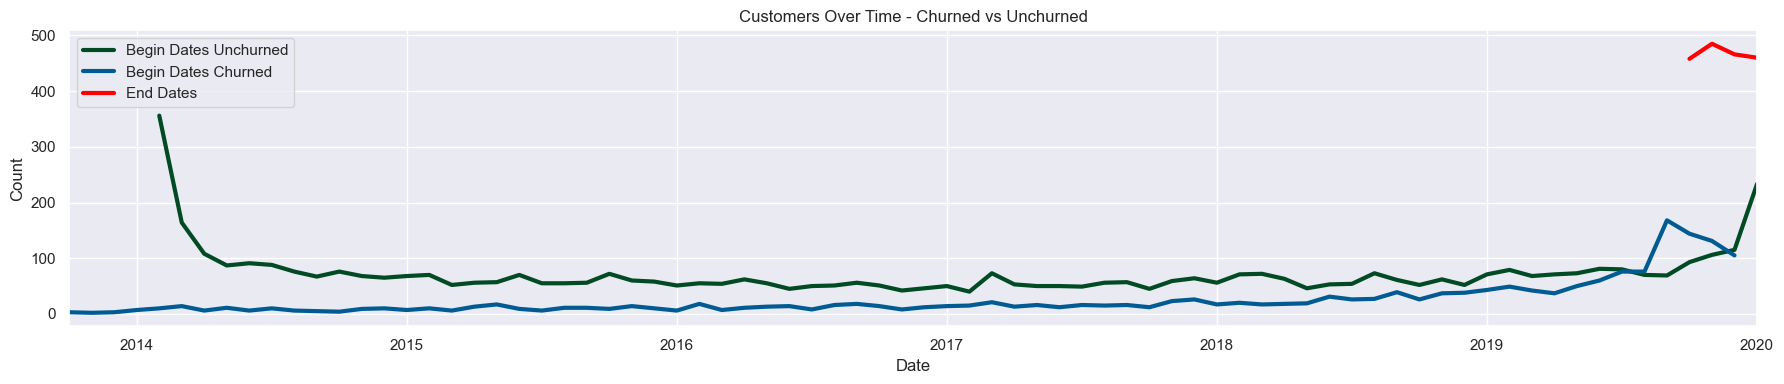

Earliest unchurned customer: 2014-02
Earliest churned customer: 2013-10
BeginDate with most churned customers: 2019-09

### Churned Customers who signed up before 2014-02 ###
     BeginDate  TenureMonths
972    2013-11            71
1302   2014-01            70
1962   2014-01            69
3035   2013-11            71
3106   2014-01            72
3433   2013-10            72
3883   2014-01            72
4505   2013-10            72
4602   2013-10            72
4676   2014-01            69
5432   2013-12            70
6029   2013-12            70
6281   2013-12            71
6389   2014-01            71
6415   2014-01            72


In [153]:
plt.figure(figsize=(18, 4))
plt.title('Customers Over Time - Churned vs Unchurned')

# Plot monthly counts for unchurned
data_all[data_all['Churn'] == False]['BeginDate'].value_counts().sort_index().plot(label="Begin Dates Unchurned", linewidth=3, color=palette[0])

# Plot monthly counts for churned
data_all[data_all['Churn'] == True]['BeginDate'].value_counts().sort_index().plot(label="Begin Dates Churned", linewidth=3, color=palette[1])

# Plot churn dates
data_all['EndDate'].value_counts().sort_index().plot(label="End Dates", linewidth=3, color='red')

# Set labels
plt.xlabel('Date')
plt.ylabel('Count')

plt.legend()
plt.show()

print(f"Earliest unchurned customer: {data_all[data_all['Churn'] == False]['BeginDate'].min()}")
print(f"Earliest churned customer: {data_all[data_all['Churn'] == True]['BeginDate'].min()}")
print(f"BeginDate with most churned customers: {data_all[data_all['Churn'] == True]['BeginDate'].value_counts().idxmax()}\n")

# print df where BeginDate is before 2014-02 and Churn is True only showing date and tenure
print("### Churned Customers who signed up before 2014-02 ###")
print(data_all[(data_all['BeginDate'] < '2014-02') & (data_all['Churn'] == True)][['BeginDate', 'TenureMonths']])

After the early peak in 2014-02, the trends of each group are relatively the same until we get to mid 2019 where more new customers are churning than staying. This adds context to the spike in new customers in mid 2019, showing that the company is having trouble retaining these new customers. The amount of churned new customers does fall back below the amount of new customers staying, but this maybe due to a lack of maturity in the data (some of the most recent customers may very well churn, but are only a few months into their contracts).

Interestingly, all of the early customers have churned, but they all had tenures near the maximum in the dataset. This shows that these early customers were with the company for a long time and only recently churned. This is a good sign for the company, as it shows that they are able to retain customers for a long time. I also don't think there is cause for concern here because we have seen that the distribution of churned customers is heavily weighted towards the lower end of tenures.  

If the churn dates were pulled correctly, these findings suggest that the company may have made a change around mid 2019 that is causing new customers to churn at a higher rate than before. This could be due to a change in marketing strategy, a change in the product, or a change in the customer service.

## Is there correlation with begin date and target variable?

In [154]:
# Check for correlation between BeginDate and Churn
# Convert BeginDate to ordinal 
data_all['BeginDateOrdinal'] = data_all['BeginDate'].apply(lambda x: x.ordinal - data_all['BeginDate'].min().ordinal)
print("Correlation between BeginDate and Churn:,", data_all['BeginDateOrdinal'].corr(data_all['Churn']))

Correlation between BeginDate and Churn:, 0.3135734076564248


There is a slight positive correlation between the begin date and the target variable. This speaks to the general shape of the begin date trend for churned customers where the number of churned customers is at or near zero until about 2017, then skyrocketing in mid 2019. 

## What are the relationships between the demographic variables and the target variable?

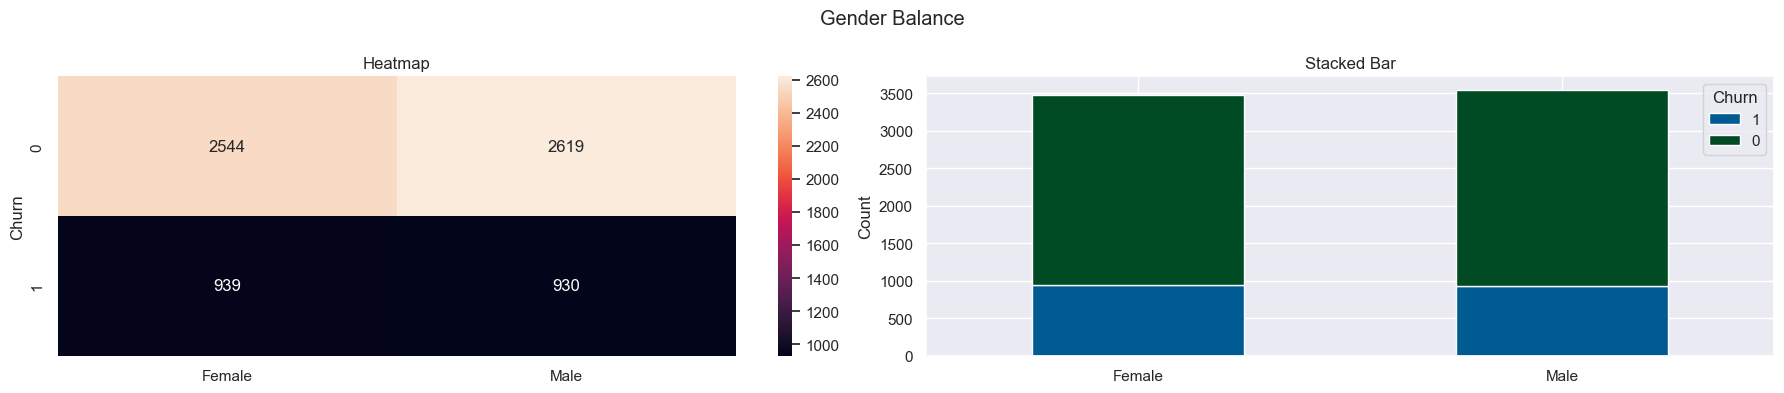

Gender,Female,Male,ShareOfCategories%
Churn,,,
0,2544,2619,49/51
1,939,930,50/50


Correlation to Gender: -0.008544643224946394


In [155]:
display(plot_column_balance(data_all, 'Gender', rotation=0))
print(f"Correlation to Gender:", data_all['Male'].corr(data_all['Churn']))

Looks like we have good balance with regard to gender. The balance between gender is about the same between churned and unchurned customers, and there is little to no correlation with the target variable.

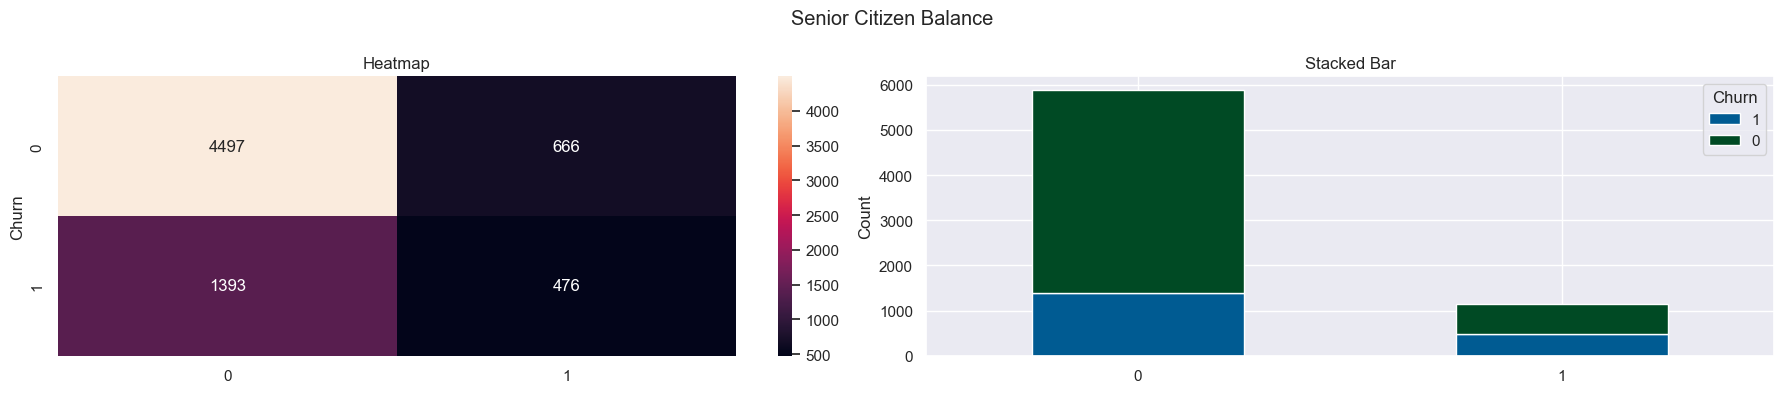

SeniorCitizen,0,1,ShareOfCategories%
Churn,,,
0,4497,666,87/13
1,1393,476,75/25


Correlation to SeniorCitizen: 0.15054105341568114


In [156]:
display(plot_column_balance(data_all, 'SeniorCitizen'))
print(f"Correlation to SeniorCitizen:", data_all['SeniorCitizen'].corr(data_all['Churn']))

There is a significant underrepresentation of senior citizens. We can see that senior citizens make up a larger share of the churned customers (25%) compared to the non-churned customers (13%). The correlation function shows a very slight positive correlation between the SeniorCitizen and the target variable.

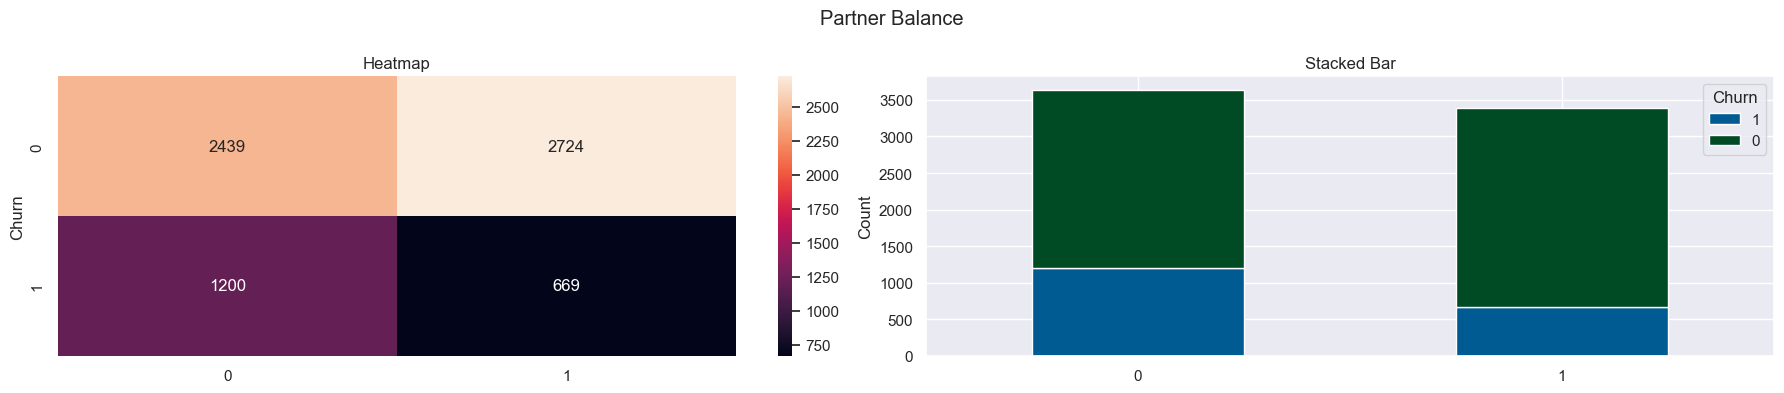

Partner,0,1,ShareOfCategories%
Churn,,,
0,2439,2724,47/53
1,1200,669,64/36


Correlation to Partner: -0.14998192562005883


In [157]:
display(plot_column_balance(data_all, 'Partner',))
print(f"Correlation to Partner:", data_all['Partner'].corr(data_all['Churn']))

Looks like we have pretty good balance for the partner column. This time we see customers without partners make up a larger share of the churned customers (53%) compared to the non-churned customers (36%). The correlation function shows a slight negative correlation between the Partner and the target variable.

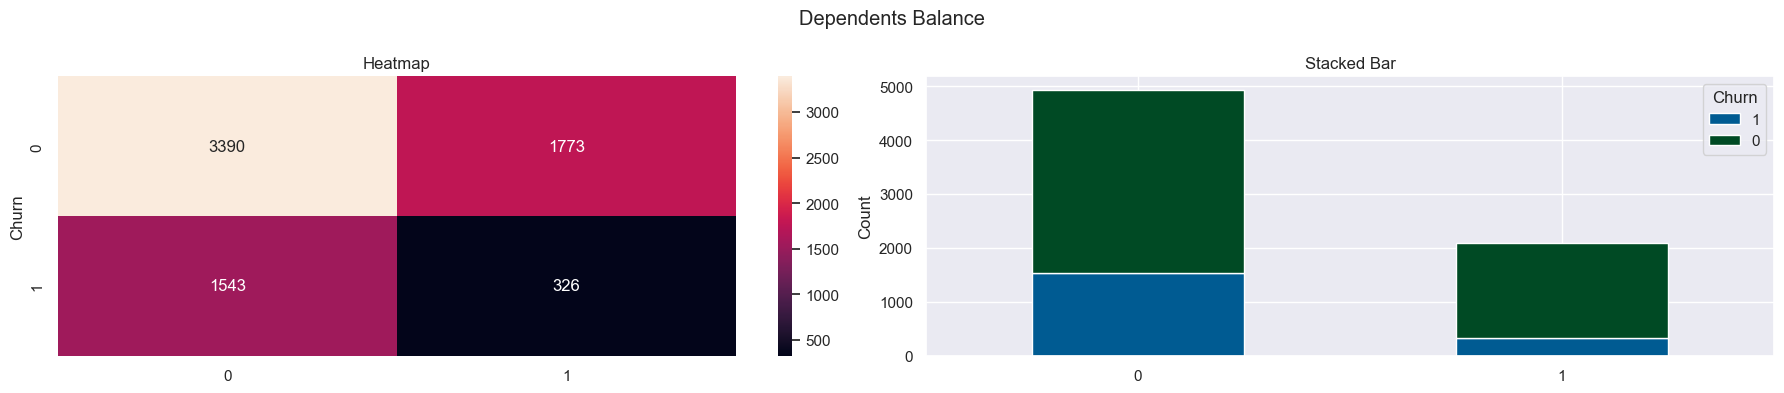

Dependents,0,1,ShareOfCategories%
Churn,,,
0,3390,1773,66/34
1,1543,326,83/17


Correlation to Dependents: -0.16312843938822041


In [158]:
display(plot_column_balance(data_all, 'Dependents'))
print(f"Correlation to Dependents:", data_all['Dependents'].corr(data_all['Churn']))

Customers with dependents are underrepresented. We can see that customers with dependents make up a smaller share of the churned customers (17%) compared to the non-churned customers (34%). The correlation function shows a slight negative correlation between the Dependents and the target variable, suggesting that customers with dependents are less likely to churn.

## What are the relationships between the services and the target variable?

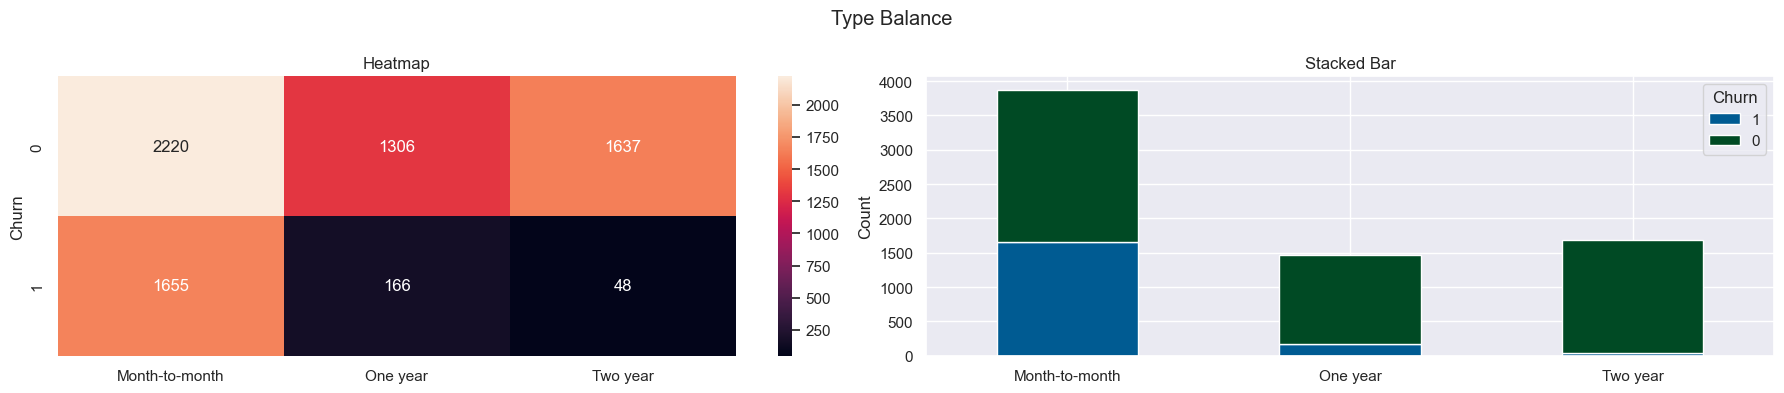

Type,Month-to-month,One year,Two year,ShareOfCategories%
Churn,,,,
0,2220,1306,1637,43/25/32
1,1655,166,48,89/9/3


In [159]:
plot_column_balance(data_all, 'Type')

Type is fairly balanced. By far month to month contracts churn the most. While non churned customers have a more even spread across the three types of contracts.

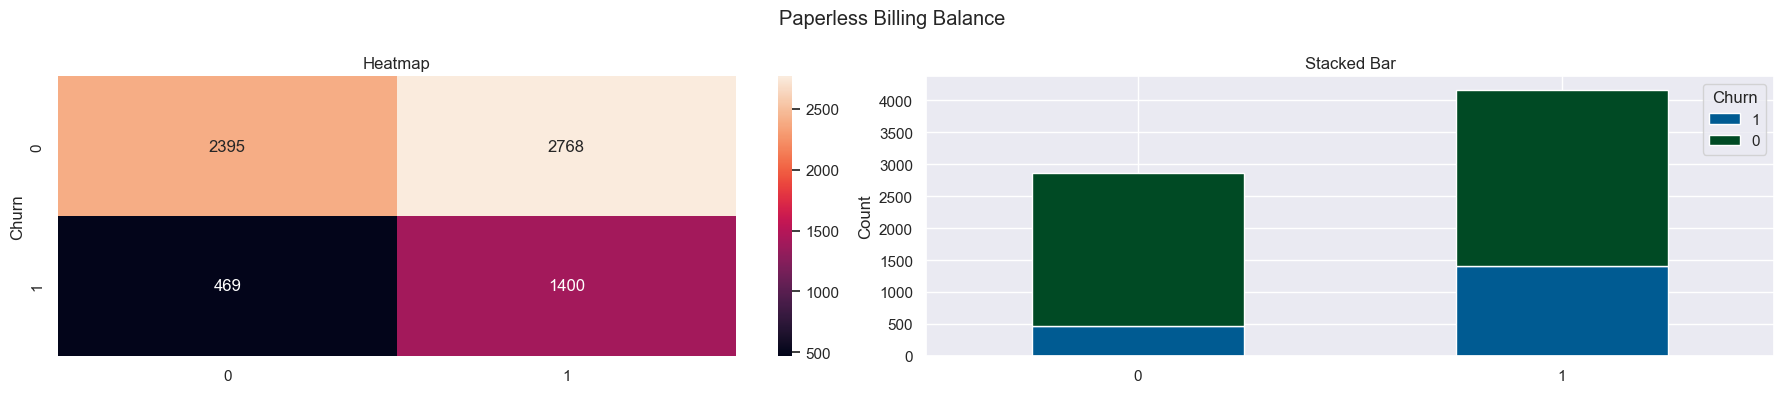

Correlation to PaperlessBilling: 0.1914543210800455


In [160]:
plot_column_balance(data_all, 'PaperlessBilling')
print(f"Correlation to PaperlessBilling:", data_all['PaperlessBilling'].corr(data_all['Churn']))

We see somewhat of an imbalance in the paperless billing column. Paperless billing customers make up a larger share of the churned customers (75%) compared to the non-churned customers (54%). The correlation function shows a slight positive correlation between the PaperlessBilling and the target variable.

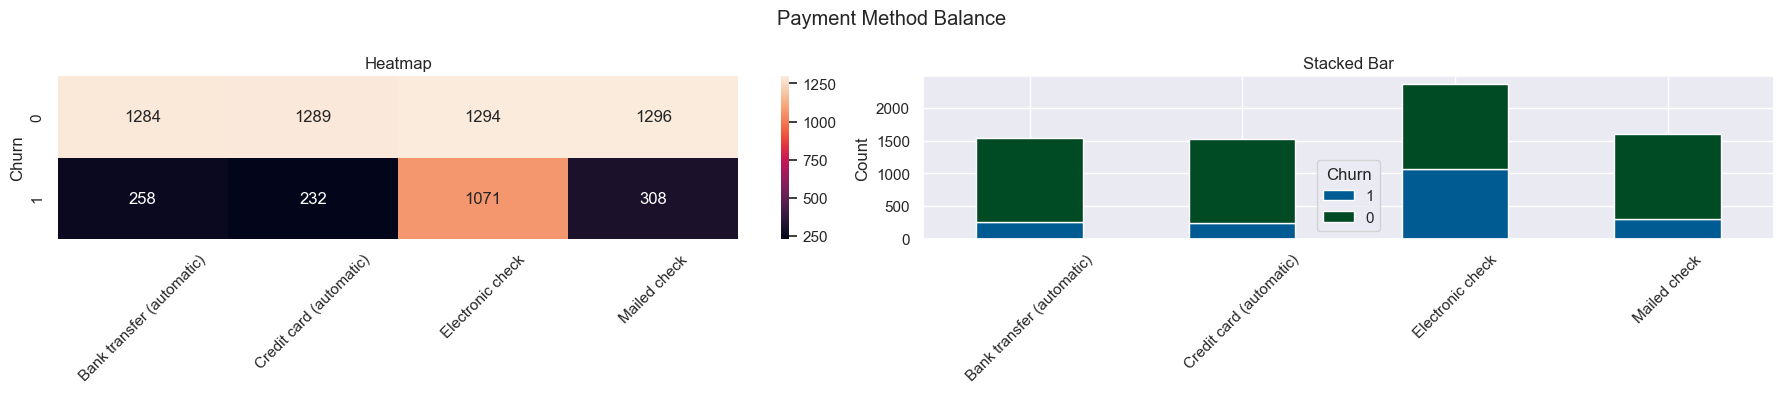

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,ShareOfCategories%
Churn,,,,,
0,1284,1289,1294,1296,25/25/25/25
1,258,232,1071,308,14/12/57/16


In [161]:
plot_column_balance(data_all, 'PaymentMethod', rotation=45)

Electronic checks are over represented by about half compared to the other payment methods (not surprising since this is a very popular option these days). The proportion of churned customers is also much larger in this group (57%) compared to the non-churned customers (25%).

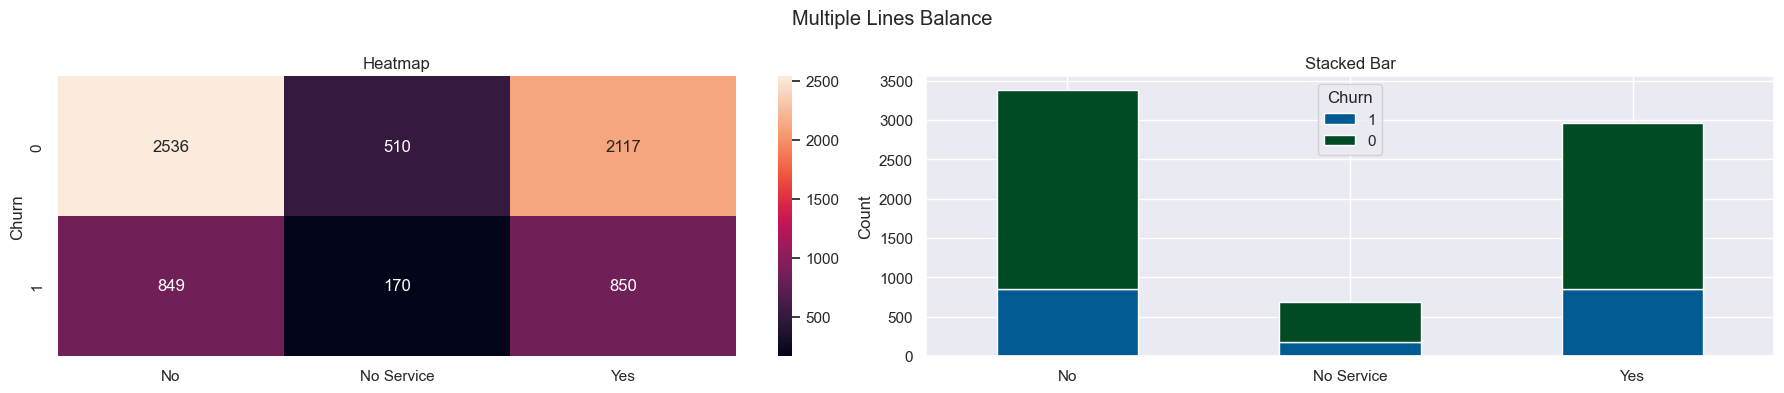

MultipleLines,No,No Service,Yes,ShareOfCategories%
Churn,,,,
0,2536,510,2117,49/10/41
1,849,170,850,45/9/45


In [162]:
display(plot_column_balance(data_all, 'MultipleLines'))

There is pretty good balance between the Yes and No categories, with few customers who had no phone service. The share between categories looks to be generally the same between the churned and unchurned customers.

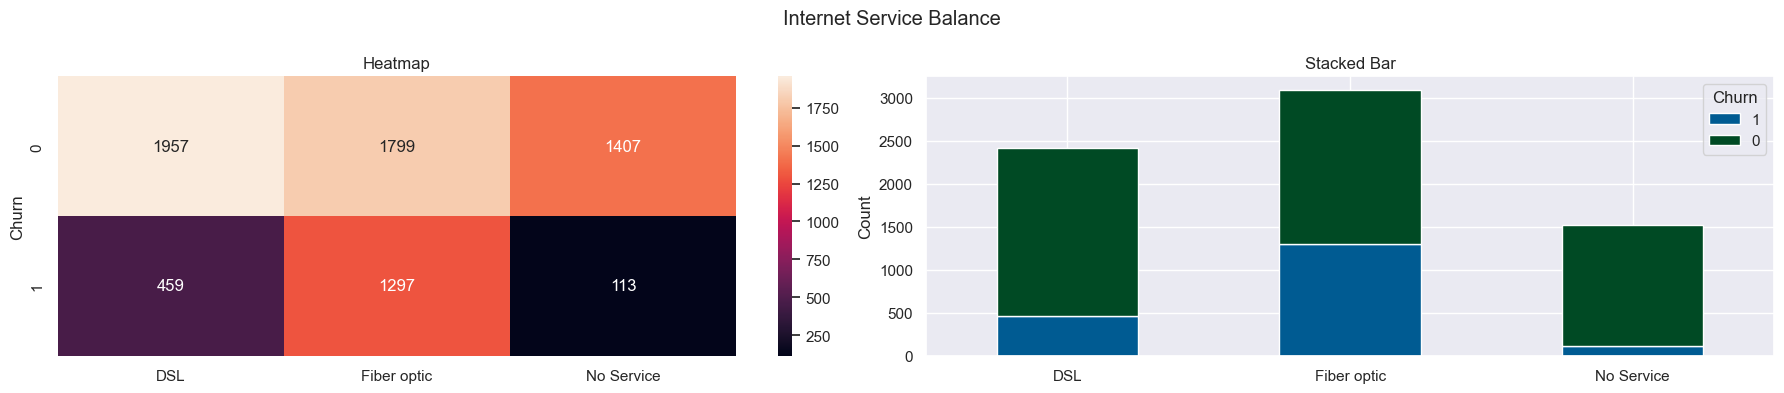

InternetService,DSL,Fiber optic,No Service,ShareOfCategories%
Churn,,,,
0,1957,1799,1407,38/35/27
1,459,1297,113,25/69/6


In [163]:
display(plot_column_balance(data_all, 'InternetService'))

There is a slight imbalance between the known categories, and a larger share of no service than in the multiple lines column. There is a greater share of Fiber Optic customers in the churned customers (69%) compared to the non-churned customers (35%), and few customers without internet service churned.

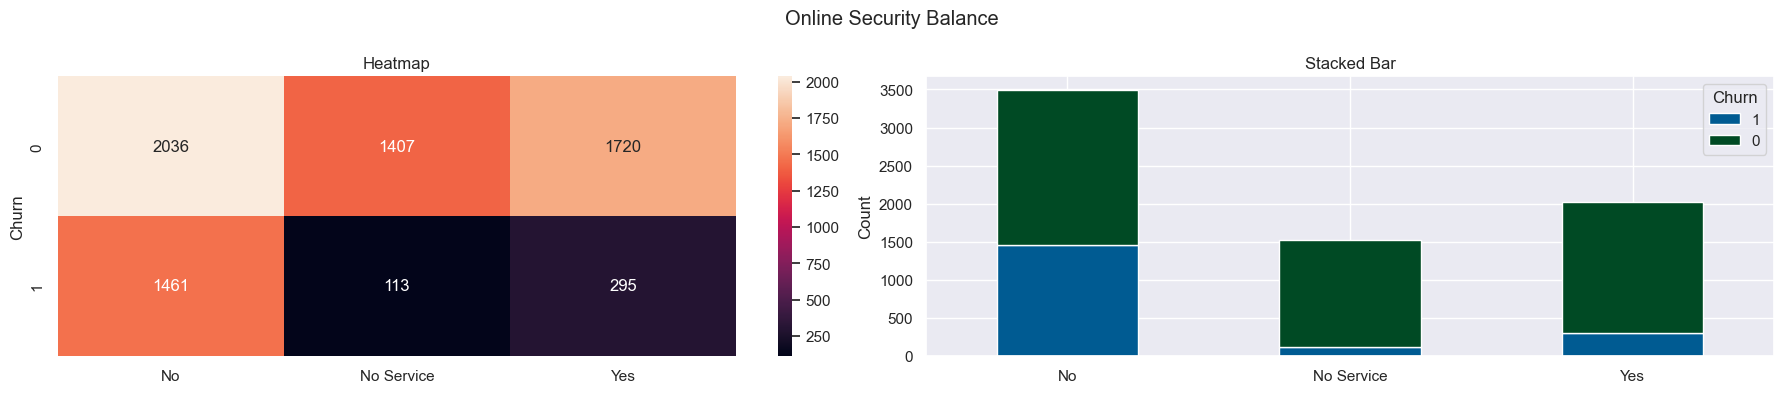

OnlineSecurity,No,No Service,Yes,ShareOfCategories%
Churn,,,,
0,2036,1407,1720,39/27/33
1,1461,113,295,78/6/16


In [164]:
display(plot_column_balance(data_all, 'OnlineSecurity'))

There is an underrepresentation of the Yes category by nearly a half. We also see customers without online security make up a larger share of the churned customers (78%) compared to the non-churned customers (39%). This could suggest that customers without online security may experience security related issues that lead to churn.

## Plan

### Prepare for Modeling

- Feature engineer the (tenure * monthly charges) - total charges relationship to get AdditionalCharges.
- Feature engineer the 'BeginDate' column to extract the month and day of week. This will allow the model to capture any seasonality or day of week effects.
- Drop the columns 'CustomerID', 'BeginDate', and 'EndDate'. 'CustomerID' is a unique identifier, 'BeginDate' will not be relevant because new customers will not have a begin date present in the training data, and 'EndDate' is essentially the target variable.
- Encode the categorical columns using OneHotEncoding, drop the first column to avoid multicollinearity.
- Create a separate dataset using the upsampling technique to balance the target variable.
- Split the data into training, validation, and test sets (60/20/20).
- Scale the features 'MonthlyCharges', 'TotalCharges', and 'Tenure' using the StandardScaler from sklearn.



### Train Models
For both datasets (original and upsampled):
- Train a DummyClassifier with the most frequent strategy to establish a baseline.
- Train a DummyClassifier with the stratified strategy to establish an additional baseline.
- Train a LogisticRegression model with class_weight='balanced' for the original dataset and None for the upsampled dataset.
- Train a RandomForestClassifier with class_weight='balanced' for the original dataset and None for the upsampled dataset. Use GridSearchCV to find the best hyperparameters considering n_estimators, max_depth, min_samples_split, and min_samples_leaf.
- Train a XGBClassifier with objective='binary:logistic', using scale_pos_weight to handle class imbalance. Use GridSearchCV to find the best hyperparameters considering n_estimators, max_depth, and learning_rate.
- Train a CatBoostClassifier with auto_class_weights='Balanced' for the original dataset and None for the upsampled dataset. Use GridSearchCV to find the best hyperparameters considering n_estimators, max_depth, and learning_rate.

### Evaluate Models

- GridsearchCV scoring='roc_auc'.  
- Secondary scoring
    - If False Negatives are more costly, then we should optimize for Recall.
    - If False Positives are more costly, then we should optimize for Precision.
    - If both are equally costly, then we should optimize for F1 Score.
- Adjust thresholds to improve the best models, with cross validation.
- Test the best model on the test set.
- Provide preliminary conclusions - more to come in the report.

# Prepare for Modeling

## Feature Engineering II

In [165]:
cat_data = data_all.copy()

# Create BeginMonth column
cat_data['BeginMonth'] = cat_data['BeginDate'].dt.to_timestamp().dt.month

# Create the BeginYear column
cat_data['BeginYear'] = cat_data['BeginDate'].dt.to_timestamp().dt.year

## Drop Columns

In [166]:
# Drop the CustomerID column - Unique identifier
# Drop the BeginDate column - We have extracted what we need
# Drop the BeginDateOrdinal column - Redundant with BeginMonth and BeginYear
# Drop the EndDate column - This is essentially the target variable expressed as a date
# Drop the TenureMonths column - Creates data leakage with the BeginMonth and BeginYear columns
# Drop the TotalCharges column - Model could associate high total charges with not churning
# Drop the Gender column - Has been re-expressed in the Male column
cat_data.drop(columns=['CustomerID', 'BeginDate', 'BeginDateOrdinal','EndDate','TenureMonths', 'TotalCharges', 'Gender'], inplace=True)

# Get the categorical features indices
categorical_features_idx = [cat_data.columns.get_loc(col) for col in cat_data.columns if cat_data[col].dtype == 'object']

## One Hot Encode

In [167]:
# Catboost can handle categorical data without encoding
encoded_data = pd.get_dummies(cat_data, drop_first=True)
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int32  
 1   Partner                                7032 non-null   int32  
 2   Dependents                             7032 non-null   int32  
 3   PaperlessBilling                       7032 non-null   int32  
 4   MonthlyCharges                         7032 non-null   float64
 5   Male                                   7032 non-null   int32  
 6   Churn                                  7032 non-null   int32  
 7   BeginMonth                             7032 non-null   int32  
 8   BeginYear                              7032 non-null   int32  
 9   Type_One year                          7032 non-null   bool   
 10  Type_Two year                          7032 non-null   bool   
 11  Paym

## Split Data

In [168]:
# Define the features and target variable
# Categorical data
X_cat = cat_data.drop(columns='Churn')
y_cat = cat_data['Churn']
# Split the data into training and testing sets
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.4, stratify=y_cat, random_state=random_state)
# Split the test set into validation and test sets
X_val_cat, X_test_cat, y_val_cat, y_test_cat = train_test_split(X_test_cat, y_test_cat, test_size=0.5, stratify=y_test_cat, random_state=random_state)


# Encoded data
X_encoded = encoded_data.drop(columns='Churn')
y_encoded = encoded_data['Churn']
# Split the data into training and testing sets
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.4, stratify=y_encoded, random_state=random_state)
# Split the test set into validation and test sets
X_val_encoded, X_test_encoded, y_val_encoded, y_test_encoded = train_test_split(X_test_encoded, y_test_encoded, test_size=0.5, stratify=y_test_encoded, random_state=random_state)

## Scale Data

Not necessary because there is only one continuous feature.

## Upsample Function

In [169]:
def upsample(features, target, repeat, random_state=random_state):
    """
    Upsamples the minority class (1) in a binary classification dataset.

    Parameters:
    - features (DataFrame): The feature matrix.
    - target (Series): The target variable.
    - repeat (int): The number of times to repeat the minority class samples.
    - random_state (int): The random seed for shuffling the upsampled data.

    Returns:
    - features_upsampled (DataFrame): The upsampled feature matrix.
    - target_upsampled (Series): The upsampled target variable.
    """

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state)

    return features_upsampled, target_upsampled

### Encoded Data ###
Churn
Stay     3098
Churn    1121
Name: count, dtype: int64


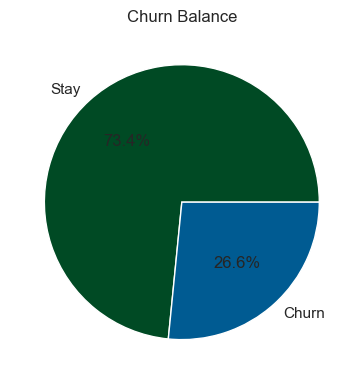

### Categorical Data ###
Churn
Stay     3098
Churn    1121
Name: count, dtype: int64


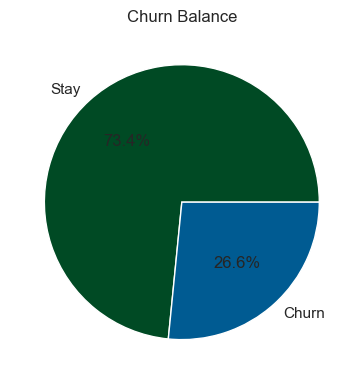

In [170]:
print("### Encoded Data ###")
plot_target_balance(pd.DataFrame(upsample(X_train_encoded, y_train_encoded, 1)[1], columns=['Churn']))
print("### Categorical Data ###")
plot_target_balance(pd.DataFrame(upsample(X_train_cat, y_train_cat, 1)[1], columns=['Churn']))

The minority class has been upsampled to bring the class balance closer to 1:1, while maintaining the minority class as the minority. 

# Train Models

In [171]:
def train_dummy_freq(X_train_encoded=X_train_encoded, y_train_encoded=y_train_encoded, X_val=X_val_encoded, y_val=y_val_encoded, random_state=random_state):
    

    # Initialize the dummy classifier
    dummy = DummyClassifier(strategy='most_frequent', random_state=random_state)

    # Fit the dummy classifier on the training data
    dummy.fit(X_train_encoded, y_train_encoded)
    
    # Predict probabilities on the positive class
    y_val_pred = dummy.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = dummy.score(X_val, y_val)
    
    # Get parameters
    params = dummy.get_params()
    
    # Dictionary to store the results
    results = {'Model': 'DummyFreq', 'Dataset': 'Original', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    # Dictionary to DF
    results = pd.DataFrame([results])
    
    return results


In [172]:
def train_dummy_stratify(X_train=X_train_encoded, y_train=y_train_encoded, X_val=X_val_encoded, y_val=y_val_encoded, random_state=random_state):
    
    # Initialize the dummy classifier
    dummy = DummyClassifier(strategy='stratified', random_state=random_state)

    # Fit the dummy classifier on the training data
    dummy.fit(X_train, y_train)
    
    # Predict probabilities on the positive class
    y_val_pred = dummy.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = dummy.score(X_val, y_val)
    
    # Get parameters
    params = dummy.get_params()
    
    # Dictionary to store the results
    results = {'Model': 'DummyStratify', 'Dataset': 'Original', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    # Dictionary to DF
    results = pd.DataFrame([results])
    
    return results

In [173]:
def train_logistic_regression(X_train=X_train_encoded, y_train=y_train_encoded, X_val=X_val_encoded, y_val=y_val_encoded, random_state=random_state, max_iter=10000):
        
    ### Original Data ###
    # Initialize the logistic regression model
    logistic = LogisticRegression(class_weight='balanced', random_state=random_state, max_iter=max_iter)
    
    # Fit the logistic regression model on the training data
    logistic.fit(X_train, y_train)
    
    # Predict probabilities on the positive class
    y_val_pred = logistic.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = logistic.score(X_val, y_val)
    
    # Get parameters
    params = logistic.get_params()
    
    # Dictionary to store the results
    results_1 = {'Model': 'LogisticRegression', 'Dataset': 'Original', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    ### Upsampled Data ###
    X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 2, random_state)
    
    # Initialize the logistic regression model
    logistic = LogisticRegression(random_state=random_state, max_iter=max_iter)
    
    # Fit the logistic regression model on the upsampled training data
    logistic.fit(X_train_upsampled, y_train_upsampled)
    
    # Predict probabilities on the positive class
    y_val_pred = logistic.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = logistic.score(X_val, y_val)
    
    # Get parameters
    params = logistic.get_params()
    
    # Dictionary to store the results
    results_2 = {'Model': 'LogisticRegression', 'Dataset': 'Upsampled', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    # Concatenate the results
    results = pd.DataFrame([results_1, results_2]).sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)
    
    return results

In [174]:
def train_rfclassifier(X_train=X_train_encoded, y_train=y_train_encoded, X_val=X_val_encoded, y_val=y_val_encoded, random_state=random_state, n_estimators=[50, 100, 300, 500], max_depth=[10, 20, 30], min_samples_split=[2, 5, 10], min_samples_leaf=[1, 2, 4], cv=3, verbose=0, n_jobs=-1):
   
    # Define the hyperparameters
    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }
    
    ### Original Data ###
    # Initialize the random forest classifier
    model = RandomForestClassifier(class_weight='balanced', random_state=random_state)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=n_jobs, verbose=verbose)

    # Fit the grid search on the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Predict probabilities on the positive class
    y_val_pred = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = best_model.score(X_val, y_val)
    
    # Get the best parameters
    params = best_model.get_params()
    
    # Dictionary to store the results
    results_1 = {'Model': 'RandomForest', 'Dataset': 'Original', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    ##########################
    ##### Upsampled Data #####
    ##########################
    best_score = 0
    best_model = None
    
    # Param grid already defined above  
    # Cross validation setup
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    # Loop through the param grid
    with tqdm(total=len(n_estimators) * len(max_depth) * len(min_samples_split) * len(min_samples_leaf), desc='Upsample Grid Search') as pbar:
        for n in n_estimators:
            for d in max_depth:
                for s in min_samples_split:
                    for l in min_samples_leaf:
                        params = {
                            'n_estimators': n,
                            'max_depth': d,
                            'min_samples_split': s,
                            'min_samples_leaf': l
                        }
                        
                        cv_scores = []
                        
                        # Perform custom cross validation
                        for train_idx, val_idx in skf.split(X_train, y_train):
                            # Split the data into training and validation sets
                            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                            
                            # Upsample the training data
                            X_train_fold_upsampled, y_train_fold_upsampled = upsample(X_train_fold, y_train_fold, 2, random_state)
                            
                            # Initialize the random forest classifier
                            model = RandomForestClassifier(class_weight=None, n_jobs=n_jobs, random_state=random_state, **params)
                            
                            # Fit the model
                            model.fit(X_train_fold_upsampled, y_train_fold_upsampled)
                            
                            # Predict probabilities on the positive class
                            y_val_pred = model.predict_proba(X_val_fold)[:, 1]
                            
                            # Calculate the ROC AUC score
                            roc_auc = roc_auc_score(y_val_fold, y_val_pred)
                            
                            # Append the score
                            cv_scores.append(roc_auc)
                        
                        # Calculate the mean score across all folds
                        mean_score = np.mean(cv_scores)
                        
                        # Update the best model if the mean score is higher
                        if mean_score > best_score:
                            best_score = mean_score
                            best_model = model
                        # Update the progress bar
                        pbar.update(1)
        
                        
    # Predict on the external validation set
    y_val_pred = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = best_model.score(X_val, y_val)
    
    # Get the best parameters
    best_params = best_model.get_params()
    
    # Dictionary to store the results
    results_2 = {'Model': 'RandomForest', 'Dataset': 'Upsampled', 'Params': best_params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    # Concatenate the results
    results = pd.DataFrame([results_1, results_2]).sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)
    
    return results

In [175]:
# Train a XGBClassifier with objective='binary:logistic', using scale_pos_weight to handle class imbalance. Use GridSearchCV to find the best hyperparameters considering n_estimators, max_depth, and learning_rate.
def train_xgbclassifier(X_train=X_train_encoded, y_train=y_train_encoded, X_val=X_val_encoded, y_val=y_val_encoded,random_state=random_state, n_estimators=[50, 100, 300, 500], max_depth=[10, 20, 30], learning_rate=[0.01, 0.1, 0.3], cv=3, verbose=0, n_jobs=1, tree_method='hist'):
    """
    Trains a XGBClassifier using GridSearchCV on both original and upsampled data.
    """
    # Convert DataFrames to numpy arrays for compatibility with XGBoost version 1.5.1
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()
    
    # Encode labels as integers
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    
    # Define the hyperparameters
    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate
    }
    
    ### Original Data ###
    # Initialize the XGBClassifier
    model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), objective='binary:logistic', random_state=random_state, use_label_encoder=False, eval_metric='logloss', tree_method=tree_method)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=n_jobs, verbose=verbose)
    
    # Fit the grid search on the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Predict probabilities on the positive class
    y_val_pred = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = best_model.score(X_val, y_val)
    
    # Get the best parameters
    params = best_model.get_params()
    
    # Dictionary to store the results
    results_1 = {'Model': 'XGBClassifier', 'Dataset': 'Original', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    ##########################
    ##### Upsampled Data #####
    ##########################
    
    best_score = 0
    best_model = None

    # Param grid already defined above
    # Cross validation setup
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    with tqdm(total=len(n_estimators) * len(max_depth) * len(learning_rate), desc='Upsample Grid Search') as pbar:
        # Loop through the param grid
        for n in n_estimators:
            for d in max_depth:
                for l in learning_rate:
                    params = {
                        'n_estimators': n,
                        'max_depth': d,
                        'learning_rate': l
                    }
                    
                    cv_scores = []
                    
                    # Perform custom cross validation
                    for train_idx, val_idx in skf.split(X_train, y_train):
                        # Split the data into training and validation sets
                        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
                        
                        # Upsample the training data
                        X_train_fold_upsampled, y_train_fold_upsampled = upsample(pd.DataFrame(X_train_fold), pd.Series(y_train_fold), 2, random_state)
                        
                        # Convert DataFrames to numpy arrays for compatibility with XGBoost version 1.5.1
                        X_train_fold_upsampled = X_train_fold_upsampled.to_numpy()
                        y_train_fold_upsampled = y_train_fold_upsampled.to_numpy()
                        
                        # Encode labels as integers
                        y_train_fold_upsampled = y_train_fold_upsampled.astype(int)
                        
                        # Initialize the XGBClassifier
                        model = XGBClassifier(objective='binary:logistic', random_state=random_state, use_label_encoder=False, eval_metric='logloss', tree_method=tree_method, **params, n_jobs=n_jobs)
                        
                        # Fit the model
                        model.fit(X_train_fold_upsampled, y_train_fold_upsampled)
                        
                        # Predict probabilities on the positive class
                        y_val_pred = model.predict_proba(X_val_fold)[:, 1]
                        
                        # Calculate the ROC AUC score
                        roc_auc = roc_auc_score(y_val_fold, y_val_pred)
                        
                        # Append the score
                        cv_scores.append(roc_auc)
                    
                    # Calculate the mean score across all folds
                    mean_score = np.mean(cv_scores)
                    
                    # Update the best model if the mean score is higher
                    if mean_score > best_score:
                        best_score = mean_score
                        best_model = model
                    # Update the progress bar
                    pbar.update(1)

    # Predict on the external validation set
    y_val_pred = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = best_model.score(X_val, y_val)
    
    # Get the best parameters
    params = best_model.get_params()
    
    # Dictionary to store the results
    results_2 = {'Model': 'XGBClassifier', 'Dataset': 'Upsampled', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    # Results to DF
    results = pd.DataFrame([results_1, results_2]).sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)
    
    return results

In [176]:
# Train a CatBoostClassifier with auto_class_weights='Balanced' for the original dataset and None for the upsampled dataset. Use GridSearchCV to find the best hyperparameters considering n_estimators, max_depth, and learning_rate.

def train_catboost(X_train=X_train_cat, y_train=y_train_cat, X_val=X_val_cat, y_val=y_val_cat, cat_features=categorical_features_idx, random_state=random_state, n_estimators=[50, 100, 300, 500], max_depth=list(range(4, 10)), learning_rate=[0.01, 0.1, 0.3], cv=3, verbose=0, n_jobs=-1, task_type='CPU'):
    """
    Trains a CatBoostClassifier using GridSearchCV on both original and upsampled data.
    """
    
    # Convert DataFrames to numpy arrays for compatibility with CatBoost version 1.0.5
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()
    
    # Convert labels into integers
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    
    # Define the hyperparameters
    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate
    }
    
    ### Original Data ###
    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(auto_class_weights='Balanced', cat_features=cat_features, verbose=0, random_state=random_state, task_type=task_type)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', verbose=verbose, n_jobs=n_jobs)
    
    # Fit the grid search on the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Predict probabilities on the positive class
    y_val_pred = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = best_model.score(X_val, y_val)
    
    # Get the best parameters
    params = best_model.get_params()
    
    # Dictionary to store the results
    results_1 = {'Model': 'CatBoostClassifier', 'Dataset': 'Original', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}
    
    ##########################
    ##### Upsampled Data #####
    ##########################
    best_score = 0
    best_model = None
    
    # Param grid already defined above
    # Cross validation setup
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    with tqdm(total=len(n_estimators) * len(max_depth) * len(learning_rate), desc='Upsample Grid Search') as pbar:
        # Loop through the param grid
        for n in n_estimators:
            for d in max_depth:
                for l in learning_rate:
                    params = {
                        'n_estimators': n,
                        'max_depth': d,
                        'learning_rate': l
                    }
                    
                    cv_scores = []
                    
                    # Perform custom cross validation
                    for train_idx, val_idx in skf.split(X_train, y_train):
                        # Split the data into training and validation sets
                        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
                        
                        # Upsample the training data
                        X_train_fold_upsampled, y_train_fold_upsampled = upsample(pd.DataFrame(X_train_fold), pd.Series(y_train_fold), 2, random_state)
                        
                        # Convert DataFrames to numpy arrays for compatibility with CatBoost version 1.0.5
                        X_train_fold_upsampled = X_train_fold_upsampled.to_numpy()
                        y_train_fold_upsampled = y_train_fold_upsampled.to_numpy()
                        
                        # Convert labels to integers
                        y_train_fold_upsampled = y_train_fold_upsampled.astype(int)
                        
                        # Initialize the CatBoostClassifier
                        model = CatBoostClassifier(auto_class_weights=None, cat_features=cat_features, verbose=0, random_state=random_state, task_type=task_type, **params)
                        
                        # Fit the model
                        model.fit(X_train_fold_upsampled, y_train_fold_upsampled)
                        
                        # Predict probabilities on the positive class
                        y_val_pred = model.predict_proba(X_val_fold)[:, 1]
                        
                        # Calculate the ROC AUC score
                        roc_auc = roc_auc_score(y_val_fold, y_val_pred)
                        
                        # Append the score
                        cv_scores.append(roc_auc)
                    
                    # Calculate the mean score across all folds
                    mean_score = np.mean(cv_scores)
                    
                    # Update the best model if the mean score is higher
                    if mean_score > best_score:
                        best_score = mean_score
                        best_model = model
                    # Update the progress bar
                    pbar.update(1)
        
    # Predict on the external validation set
    y_val_pred = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    # Calculate the accuracy
    val_accuracy = best_model.score(X_val, y_val)
    
    # Get the best parameters
    params = best_model.get_params()
    
    # Dictionary to store the results
    results_2 = {'Model': 'CatBoostClassifier', 'Dataset': 'Upsampled', 'Params': params, 'ROC_AUC': roc_auc, 'Accuracy': val_accuracy}

    # Concatenate the results
    results = pd.DataFrame([results_1, results_2]).sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)
    
    return results

In [177]:
def results_to_code(df):
    
    for i, row in df.iterrows():
        # If last row
        if i + 1 == len(df):
            print(f"{row.to_dict()}".replace("nan", "np.nan"))
        else:
            print(f"{row.to_dict()}".replace("nan", "np.nan") + ",\n")

In [178]:
if input("Do you want to train and tune the models? If not, the results will be loaded from the code in the else block. (y/n): ").lower() == 'y':
    train_models = True
else:
    train_models = False

n_estimators=[50, 100, 300, 500, 600, 750, 1000]
max_depth=[None]+list(range(1, 10))+[10, 20, 30]
min_samples_split=[2, 5, 10, 15, 20]
learning_rate=[0.005, 0.01, 0.05, 0.1, 0.3]

if train_models:

    print("Training Dummy Freq...")
    dummy_freq_results = train_dummy_freq()
    
    print("\nTraining Dummy Stratify...")
    dummy_stratify_results = train_dummy_stratify()
    
    print("\nTraining Logistic Regression...")
    lr_results = train_logistic_regression()

    print("\nTraining Random Forest...")
    rf_results = train_rfclassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, verbose=1)

    print("\nTraining XGBClassifier...")
    xgb_results = train_xgbclassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbose=1)

        
    print("\nTraining CatBoostClassifier...")
    catboost_results = train_catboost(n_estimators=n_estimators, learning_rate=learning_rate, verbose=1) # catboost has a max_depth of 16 and works best in the range of 4-10 as per the documentation.
    
    # Concatenate the results
    results = pd.concat([dummy_freq_results, dummy_stratify_results, lr_results, rf_results, xgb_results, catboost_results], ignore_index=True)
    
    results_to_code(results)

else: # Results from training the models as translated by the results_to_code function:

    results = pd.DataFrame([
        {'Model': 'DummyFreq', 'Dataset': 'Original', 'Params': {'constant': None, 'random_state': 42, 'strategy': 'most_frequent'}, 'ROC_AUC': 0.5, 'Accuracy': 0.7339971550497866},

        {'Model': 'DummyStratify', 'Dataset': 'Original', 'Params': {'constant': None, 'random_state': 42, 'strategy': 'stratified'}, 'ROC_AUC': 0.49498922190440653, 'Accuracy': 0.6052631578947368},

        {'Model': 'LogisticRegression', 'Dataset': 'Original', 'Params': {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}, 'ROC_AUC': 0.8243274053807569, 'Accuracy': 0.7204836415362731},

        {'Model': 'LogisticRegression', 'Dataset': 'Upsampled', 'Params': {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}, 'ROC_AUC': 0.8238584545869085, 'Accuracy': 0.7524893314366998},

        {'Model': 'RandomForest', 'Dataset': 'Original', 'Params': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, 'ROC_AUC': 0.8400100526468515, 'Accuracy': 0.7745376955903271},

        {'Model': 'RandomForest', 'Dataset': 'Upsampled', 'Params': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, 'ROC_AUC': 0.8361781287567881, 'Accuracy': 0.783072546230441},

        {'Model': 'XGBClassifier', 'Dataset': 'Original', 'Params': {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 1, 'min_child_weight': 1, 'missing': np.nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 2.7636039250669047, 'subsample': 1, 'tree_method': 'hist', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'}, 'ROC_AUC': 0.843475365833437, 'Accuracy': 0.7389758179231863},

        {'Model': 'XGBClassifier', 'Dataset': 'Upsampled', 'Params': {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 1, 'min_child_weight': 1, 'missing': np.nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'hist', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'}, 'ROC_AUC': 0.8426993947684782, 'Accuracy': 0.7702702702702703},

        {'Model': 'CatBoostClassifier', 'Dataset': 'Original', 'Params': {'learning_rate': 0.01, 'verbose': 0, 'auto_class_weights': 'Balanced', 'task_type': 'CPU', 'max_depth': 4, 'n_estimators': 1000, 'random_state': 42, 'cat_features': [3, 5, 7, 8, 9, 10, 11, 12, 13, 14]}, 'ROC_AUC': 0.8453058284624633, 'Accuracy': 0.7311522048364154},

        {'Model': 'CatBoostClassifier', 'Dataset': 'Upsampled', 'Params': {'learning_rate': 0.01, 'verbose': 0, 'task_type': 'CPU', 'max_depth': 4, 'n_estimators': 1000, 'random_state': 42, 'cat_features': [3, 5, 7, 8, 9, 10, 11, 12, 13, 14]}, 'ROC_AUC': 0.8413314057123906, 'Accuracy': 0.7610241820768137}
    ])

# Sort by ROC_AUC, then by Accuracy
results = results.sort_values(by=['ROC_AUC', 'Accuracy'], ascending=False).reset_index(drop=True)

# Evaluate Models

In [179]:
display(results)

,Model,Dataset,Params,ROC_AUC,Accuracy
0,CatBoostClassifier,Original,"{'learning_rate': 0.01, 'verbose': 0, 'auto_cl...",0.845306,0.731152
1,XGBClassifier,Original,"{'objective': 'binary:logistic', 'use_label_en...",0.843475,0.738976
2,XGBClassifier,Upsampled,"{'objective': 'binary:logistic', 'use_label_en...",0.842699,0.770270
3,CatBoostClassifier,Upsampled,"{'learning_rate': 0.01, 'verbose': 0, 'task_ty...",0.841331,0.761024
4,RandomForest,Original,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.840010,0.774538
5,RandomForest,Upsampled,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.836178,0.783073
6,LogisticRegression,Original,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.824327,0.720484
7,LogisticRegression,Upsampled,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.823858,0.752489
8,DummyFreq,Original,"{'constant': None, 'random_state': 42, 'strate...",0.500000,0.733997
9,DummyStratify,Original,"{'constant': None, 'random_state': 42, 'strate...",0.494989,0.605263


We have some good results here, but I want to check if any of the hyperparameters were at the limits of the default grid search.

In [180]:
def review_results_hyperparams(results=results):
    
    for i, row in results.iterrows():
        # Get hyperparameters
        try:
            n_estimators = row['Params']['n_estimators']
        except:
            n_estimators = 'EXCLUDE'
        try:
            max_depth = row['Params']['max_depth']
        except:
            max_depth = 'EXCLUDE'
        try:
            min_samples_split = row['Params']['min_samples_split']
        except:
            min_samples_split = 'EXCLUDE'
        try:
            min_samples_leaf = row['Params']['min_samples_leaf']
        except:
            min_samples_leaf = 'EXCLUDE'
        try:
            learning_rate = row['Params']['learning_rate']
        except:
            learning_rate = 'EXCLUDE'
        
        # Make dictionary
        hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'learning_rate': learning_rate}
        
        # Print hyperparameters
        print(f"    {row['Model']}: {hyperparameters}")
        
print(f'n_estimators: {n_estimators}\nmax_depth: {max_depth}\nmin_samples_split: {min_samples_split}\nlearning_rate: {learning_rate}\n')
review_results_hyperparams()

n_estimators: [50, 100, 300, 500, 600, 750, 1000]
max_depth: [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]
min_samples_split: [2, 5, 10, 15, 20]
learning_rate: [0.005, 0.01, 0.05, 0.1, 0.3]

    CatBoostClassifier: {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 'EXCLUDE', 'min_samples_leaf': 'EXCLUDE', 'learning_rate': 0.01}
    XGBClassifier: {'n_estimators': 100, 'max_depth': 1, 'min_samples_split': 'EXCLUDE', 'min_samples_leaf': 'EXCLUDE', 'learning_rate': 0.3}
    XGBClassifier: {'n_estimators': 1000, 'max_depth': 1, 'min_samples_split': 'EXCLUDE', 'min_samples_leaf': 'EXCLUDE', 'learning_rate': 0.05}
    CatBoostClassifier: {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 'EXCLUDE', 'min_samples_leaf': 'EXCLUDE', 'learning_rate': 0.01}
    RandomForest: {'n_estimators': 1000, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 1, 'learning_rate': 'EXCLUDE'}
    RandomForest: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 20, 'min_samp

Looks like we might be able to get even better performance out the best model by increasing n_estimators and max_depth. Lets try that.

In [181]:
if train_models:
    # Try to get better results out of the best model
    catboost_results_2 = train_catboost(n_estimators=[1250, 1500, 1750, 2000], learning_rate=learning_rate, verbose=1)
    
    results_to_code(catboost_results_2)
      
else:

    catboost_results_2 = pd.DataFrame([
    {'Model': 'CatBoostClassifier', 'Dataset': 'Original', 'Params': {'learning_rate': 0.01, 'verbose': 0, 'auto_class_weights': 'Balanced', 'task_type': 'CPU', 'max_depth': 4, 'n_estimators': 1250, 'random_state': 42, 'cat_features': [3, 5, 7, 8, 9, 10, 11, 12, 13, 14]}, 'ROC_AUC': 0.845518281308295, 'Accuracy': 0.7389758179231863},

    {'Model': 'CatBoostClassifier', 'Dataset': 'Upsampled', 'Params': {'learning_rate': 0.01, 'verbose': 0, 'task_type': 'CPU', 'max_depth': 4, 'n_estimators': 1250, 'random_state': 42, 'cat_features': [3, 5, 7, 8, 9, 10, 11, 12, 13, 14]}, 'ROC_AUC': 0.8418340380549683, 'Accuracy': 0.767425320056899}
    ])
        
    
results = pd.concat([results, catboost_results_2], ignore_index=True).sort_values(by=['ROC_AUC', 'Accuracy'], ascending=False) # Don't reset index to keep track of the order

display(results)

,Model,Dataset,Params,ROC_AUC,Accuracy
10,CatBoostClassifier,Original,"{'learning_rate': 0.01, 'verbose': 0, 'auto_cl...",0.845518,0.738976
0,CatBoostClassifier,Original,"{'learning_rate': 0.01, 'verbose': 0, 'auto_cl...",0.845306,0.731152
1,XGBClassifier,Original,"{'objective': 'binary:logistic', 'use_label_en...",0.843475,0.738976
2,XGBClassifier,Upsampled,"{'objective': 'binary:logistic', 'use_label_en...",0.842699,0.770270
11,CatBoostClassifier,Upsampled,"{'learning_rate': 0.01, 'verbose': 0, 'task_ty...",0.841834,0.767425
3,CatBoostClassifier,Upsampled,"{'learning_rate': 0.01, 'verbose': 0, 'task_ty...",0.841331,0.761024
4,RandomForest,Original,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.840010,0.774538
5,RandomForest,Upsampled,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.836178,0.783073
6,LogisticRegression,Original,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.824327,0.720484
7,LogisticRegression,Upsampled,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.823858,0.752489


In [182]:
print(results['Params'][10])

{'learning_rate': 0.01, 'verbose': 0, 'auto_class_weights': 'Balanced', 'task_type': 'CPU', 'max_depth': 4, 'n_estimators': 1250, 'random_state': 42, 'cat_features': [3, 5, 7, 8, 9, 10, 11, 12, 13, 14]}


We get ever so slightly better results with more estimators, but we look to be at or near the limit of the model's performance. Lets move on to the final evaluation.

In [183]:
results = results.reset_index(drop=True)

In [184]:
def test_catboost(X_train=X_train_cat, y_train=y_train_cat, X_val=X_val_cat, y_val=y_val_cat, X_test=X_test_cat, y_test=y_test_cat, params=results['Params'][0], random_state=random_state):
    
    # Combine the training and validation sets
    X_train = pd.concat([X_train, X_val])
    y_train = pd.concat([y_train, y_val])
    
    # Get predictions from the DummyFreq model for plotting on the roc curve
    dummy_freq = DummyClassifier(strategy='most_frequent', random_state=random_state)
    dummy_freq.fit(X_train, y_train)
    y_test_pred_dummy_freq = dummy_freq.predict_proba(X_test)[:, 1]
    dummy_fp, dummy_tp, dummy_thresholds = roc_curve(y_test, y_test_pred_dummy_freq)
    
    # Convert DataFrames to numpy arrays for compatibility with CatBoost version 1.0.5
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
    
    # Encode labels as integers
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(**params)
    
    # Fit the model on the training data
    train_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - train_time
    
    # Predict probabilities on the positive class
    predict_time = time.time()
    y_test_pred = model.predict_proba(X_test)[:, 1]
    predict_time = time.time() - predict_time
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_test_pred)
    
    # Calculate the accuracy
    accuracy = model.score(X_test, y_test)
    
    # Calculate the roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    
    # Find the best threshold
    best_accuracy = 0
    best_threshold = 0
    for threshold in thresholds:
        y_test_pred_threshold = y_test_pred > threshold
        accuracy_threshold = accuracy_score(y_test, y_test_pred_threshold)
        if accuracy_threshold > best_accuracy:
            best_accuracy = accuracy_threshold
            best_threshold = threshold
            
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label='CatBoost') # CatBoost
    plt.plot(dummy_fp, dummy_tp, label='DummyFreq', linestyle='--', color='orange') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('Best Model ROC Curve')
    plt.show()
    
    # Confusion Matrix with best threshold
    y_test_pred_threshold = y_test_pred > best_threshold
    cm = confusion_matrix(y_test, y_test_pred_threshold)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix for Best Model with Best Threshold')
    plt.xlabel('Predicted')
    plt.xticks([0.5, 1.5], ['False', 'True'])
    plt.ylabel('Actual')
    plt.yticks([0.5, 1.5], ['False', 'True'])
    plt.show()
    
    print("Results from test set:")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy before threshold adjustment: {accuracy:.4f}")
    print(f"Best threshold: {best_threshold:.4f}, Best Accuracy: {best_accuracy:.4f}")
    print(f"The model trains in {train_time*1000:.0f} milliseconds and predicts in {predict_time*1000:.0f} milliseconds.")
    
    return model, best_threshold

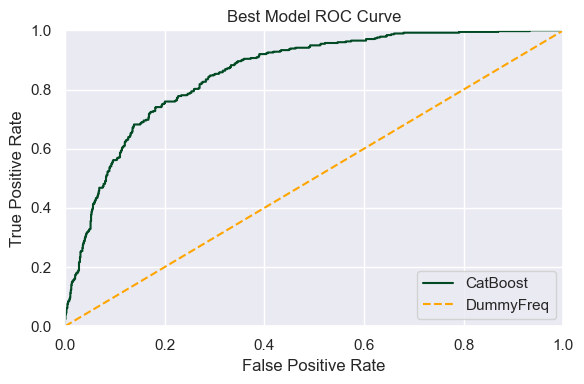

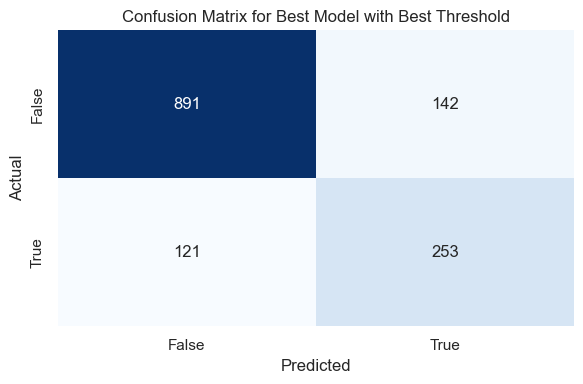

Results from test set:
ROC AUC: 0.8555
Accuracy before threshold adjustment: 0.7377
Best threshold: 0.6933, Best Accuracy: 0.8131
The model trains in 4523 milliseconds and predicts in 5 milliseconds.

Results from validation set:
ROC AUC: 0.8455
Accuracy: 0.7390


In [185]:
best_model, threshold = test_catboost()
print("\nResults from validation set:")
print(f"ROC AUC: {results['ROC_AUC'][0]:.4f}")
print(f"Accuracy: {results['Accuracy'][0]:.4f}")

## Results

The model performs even better on the test set with a ROC_AUC score of 85.55%, an improvement of about 1%.The CatBoost model significantly outperforms the dummy classifier, as indicated by its ROC curve being much closer to the top-left corner, demonstrating strong discriminative ability in predicting the target variable.

Additionally, the model's accuracy score can be improved considerably from 73.77% to 81.31%% (+7.54%) by adjusting the threshold to approximately 0.6969 (the true value is stored in the variable 'threshold').

With the threshold adjustment, the model performs well with 121 false positives and 142 false negatives, maintaining a good balance between each as specified by Interconnect. 

## Feature Importance

In [186]:
feature_importance = best_model.get_feature_importance(data=Pool(
    pd.concat([X_train_cat, X_val_cat]).to_numpy(),
    label=pd.concat([y_train_cat, y_val_cat]).to_numpy().astype(int),
    cat_features=categorical_features_idx), type='LossFunctionChange')

feature_importance = pd.DataFrame({'Feature': X_train_cat.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False).reset_index(drop=False).rename(columns={'index': 'ColumnIDX'})
display(feature_importance.head(10))

,ColumnIDX,Feature,Importance
0,3,Type,0.046859
1,17,BeginYear,0.030858
2,9,OnlineSecurity,0.010583
3,8,InternetService,0.007578
4,16,BeginMonth,0.006498
5,6,MonthlyCharges,0.005500
6,12,TechSupport,0.003787
7,4,PaperlessBilling,0.002202
8,5,PaymentMethod,0.002188
9,10,OnlineBackup,0.001765


Our second most important feature is the Begin year, but given our earlier insight that there were no churned customers until mid 2019, and that the distribution of churned customers is heavily weighted towards more recent years, I'm not convinced that the data for our target variable was pulled correctly. It seems as if the data for churned customers was only pulled from 2019 forward. If that is the case, then the Begin year is causing data leakage and should be removed from the training features.

**Note:** The representation of some churned customers with a BEGIN date before 2019 is because some customers very well could have signed up before 2019, but churned in 2019. One would suspect for the distribution of churned customers to be more evenly spread out across the years if the data was pulled correctly.

Let's train the best model again, but with the begin date column removed to see how the model performs without it.

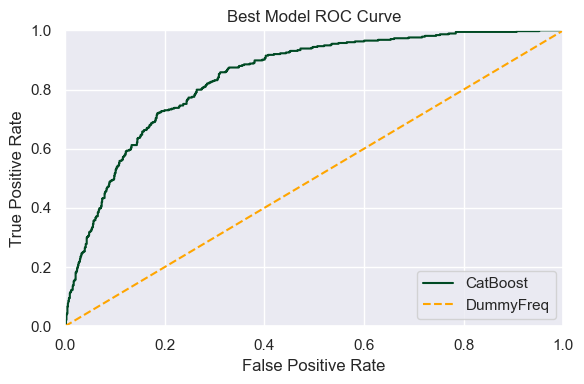

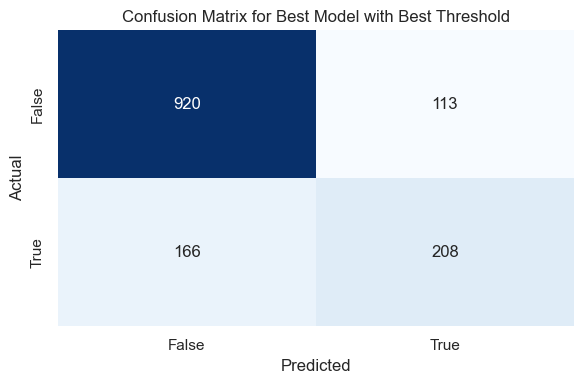

Results from test set:
ROC AUC: 0.8417
Accuracy before threshold adjustment: 0.7385
Best threshold: 0.7310, Best Accuracy: 0.8017
The model trains in 4293 milliseconds and predicts in 4 milliseconds.


,ColumnIDX,Feature,Importance
0,3,Type,0.063782
1,8,InternetService,0.012192
2,16,BeginMonth,0.011973
3,9,OnlineSecurity,0.010981
4,5,PaymentMethod,0.005004
5,12,TechSupport,0.004033
6,6,MonthlyCharges,0.003636
7,10,OnlineBackup,0.003077
8,4,PaperlessBilling,0.002314
9,1,Partner,0.001605


In [187]:
best_model_without_begin_year, threshold_without_begin_year = test_catboost(X_train=X_train_cat.drop(columns=['BeginYear']), X_val=X_val_cat.drop(columns=['BeginYear']), X_test=X_test_cat.drop(columns=['BeginYear']), params=results['Params'][0])

feature_importance_without_begin_year = best_model_without_begin_year.get_feature_importance(data=Pool(
    pd.concat([X_train_cat.drop(columns=['BeginYear']), X_val_cat.drop(columns=['BeginYear'])]).to_numpy(),
    label=pd.concat([y_train_cat, y_val_cat]).to_numpy().astype(int),
    cat_features=categorical_features_idx), type='LossFunctionChange')
                                                                                
feature_importance_without_begin_year = pd.DataFrame({'Feature': X_train_cat.drop(columns=['BeginYear']).columns, 'Importance': feature_importance_without_begin_year}).sort_values(by='Importance', ascending=False).reset_index(drop=False).rename(columns={'index': 'ColumnIDX'})

display(feature_importance_without_begin_year.head(10))

The model performs slightly worse without the Begin year feature, but is still a strong performer with a ROC_AUC score of 84.17% and an accuracy score of 80.17%.  

The most important feature is the (contract) type in both instances (but much more so when begin year is dropped from the features). This coincides with our findings in the EDA where we saw that month to month contracts churn the most and two year contracts churn the least.

Internet service type is also a strong feature, we noted in EDA that fiber optic customers churn the most. This suggest that customers may be dissatisfied with the fiber optic service.

Begin month also looks to be a strong feature, suggesting some seasonal relationship with churn. 

# Recommendations

Given the similar performance of the model with and without the begin year feature, and the project lead's assurance that the data is correct, this model, trained with the begin year as part of the features, looks to be a strong candidate for deployment. If the model begins to underperform, I would recommend triple checking the data for the target variable to ensure that it is being pulled correctly. The company could also retrain the model with the Begin year feature removed to see if the model's in production performance improves.

# Solution Report

1. What steps of the plan were performed and what steps were skipped (explain why)?
    - Skipped feature engineering AdditionalCharges once determining tenure caused data leakage (AdditionalCharges was derived from TotalCharges).
    - Once TotalCharges, AdditionalCharges, and Tenure were determined to cause data leakage, there was no longer a need to scale the features because there was only one continuous feature left.
    - Instead of upsampling the data once and passing it to each tuning function, I used the upsample function in each tuning function. This was necessary to properly perform cross validation with grid search.


2. What difficulties did you encounter and how did you manage to solve them?
    - Data leakage was the most difficult problem to solve. I had to carefully consider if TotalCharges was causing data leakage because TotalCharges is a value that in one sense is known at the time of prediction. When training however, TotalCharges is not an apples to apples comparison between the churned and unchurned customers. Consider that for churned customers TotalCharges is static known value, but for unchurned customers TotalCharges is a value that is still being accumulated. 
    - I also had to consider if multiple features interacted to create data leakage. For example, Tenure and BeginDate could cause data leakage if used together because the model could infer if a customer churned based on the sum of the two features compared to the max date in the dataset.
    - Grid search cross validation with upsampled data also caused some difficulty. I had to create a custom approach to grid search cross validation that would upsample the data before each fold. This was necessary to prevent data leakage in the validation process.

3. What were some of the key steps to solving the task?
    - Determining the class imbalance and having multiple strategies to deal with it for each model.
    - Thorough exploratory data analysis to understand the data, recognize risks of data leakage, and guide feature engineering.
    - The use of grid search to efficiently tune hyperparameters.

4. What is your final model and what quality score does it have?
    - My final model was a CatBoostClassifier using the original data set (not upsampled) with the parameters: {  'learning_rate': 0.01,  
    'verbose': 0,  
    'auto_class_weights': 'Balanced',  
    'task_type': 'CPU',  
    'max_depth': 4,  
    'n_estimators': 1250,  
    'random_state': 42,  
    'cat_features': [3, 5, 7, 8, 9, 10, 11, 12, 13, 14]
    }
    - The final model is stored in the variable 'best_model', or its parameters can be pulled from the results DataFrame.
    - The final model has a ROC_AUC score of 85.55% and an accuracy score of 81.31%.